# Deep learning project: time series forecasting with recurrent neural networks (RNNs)

This project uses the Kaggle dataset [Electric Power Consumption](https://www.kaggle.com/datasets/fedesoriano/electric-power-consumption).

We build long-short term memory (LSTM) models to learn this time series data and make predictions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM, GRU
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor

import warnings
warnings.filterwarnings('ignore')

# 1. Data loading and exploration

In [2]:
df = pd.read_csv('power_consumption.csv')
df.head()

Datetime  Temperature  Humidity  WindSpeed  GeneralDiffuseFlows  \
0  1/1/2017 0:00        6.559      73.8      0.083                0.051   
1  1/1/2017 0:10        6.414      74.5      0.083                0.070   
2  1/1/2017 0:20        6.313      74.5      0.080                0.062   
3  1/1/2017 0:30        6.121      75.0      0.083                0.091   
4  1/1/2017 0:40        5.921      75.7      0.081                0.048   

   DiffuseFlows  PowerConsumption_Zone1  PowerConsumption_Zone2  \
0         0.119             34055.69620             16128.87538   
1         0.085             29814.68354             19375.07599   
2         0.100             29128.10127             19006.68693   
3         0.096             28228.86076             18361.09422   
4         0.085             27335.69620             17872.34043   

   PowerConsumption_Zone3  
0             20240.96386  
1             20131.08434  
2             19668.43373  
3             18899.27711  
4             18442.40964

In [31]:
#print(df.head().to_latex(caption = 'First 5 lines of the dataset.', label = 'tab:head', float_format = '%.2f', index = False))

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52416 entries, 0 to 52415
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Datetime                52416 non-null  float64
 1   Temperature             52416 non-null  float64
 2   Humidity                52416 non-null  float64
 3   WindSpeed               52416 non-null  float64
 4   GeneralDiffuseFlows     52416 non-null  float64
 5   DiffuseFlows            52416 non-null  float64
 6   PowerConsumption_Zone1  52416 non-null  float64
 7   PowerConsumption_Zone2  52416 non-null  float64
 8   PowerConsumption_Zone3  52416 non-null  float64
dtypes: float64(9)
memory usage: 3.6 MB


In [34]:
df.isnull().sum()

Datetime                  0
Temperature               0
Humidity                  0
WindSpeed                 0
GeneralDiffuseFlows       0
DiffuseFlows              0
PowerConsumption_Zone1    0
PowerConsumption_Zone2    0
PowerConsumption_Zone3    0
dtype: int64

In [5]:
datetime_convert = pd.to_datetime(df["Datetime"], errors = 'coerce')
datetime_convert.isnull().any()

np.False_

In [6]:
reference_date = pd.to_datetime(df['Datetime'][0])
days = (datetime_convert - reference_date).dt.total_seconds() / 24 / 3600
days

0          0.000000
1          0.006944
2          0.013889
3          0.020833
4          0.027778
            ...    
52411    363.965278
52412    363.972222
52413    363.979167
52414    363.986111
52415    363.993056
Name: Datetime, Length: 52416, dtype: float64

In [7]:
df['Datetime'] = days
df

Datetime  Temperature  Humidity  WindSpeed  GeneralDiffuseFlows  \
0        0.000000        6.559      73.8      0.083                0.051   
1        0.006944        6.414      74.5      0.083                0.070   
2        0.013889        6.313      74.5      0.080                0.062   
3        0.020833        6.121      75.0      0.083                0.091   
4        0.027778        5.921      75.7      0.081                0.048   
...           ...          ...       ...        ...                  ...   
52411  363.965278        7.010      72.4      0.080                0.040   
52412  363.972222        6.947      72.6      0.082                0.051   
52413  363.979167        6.900      72.8      0.086                0.084   
52414  363.986111        6.758      73.0      0.080                0.066   
52415  363.993056        6.580      74.1      0.081                0.062   

       DiffuseFlows  PowerConsumption_Zone1  PowerConsumption_Zone2  \
0             0.119             34055.69620             16128.87538   
1             0.085             29814.68354             19375.07599   
2             0.100             29128.10127             19006.68693   
3             0.096             28228.86076             18361.09422   
4             0.085             27335.69620             17872.34043   
...             ...                     ...                     ...   
52411         0.096             31160.45627             26857.31820   
52412         0.093             30430.41825             26124.57809   
52413         0.074             29590.87452             25277.69254   
52414         0.089             28958.17490             24692.23688   
52415         0.111             28349.80989             24055.23167   

       PowerConsumption_Zone3  
0                 20240.96386  
1                 20131.08434  
2                 19668.43373  
3                 18899.27711  
4                 18442.40964  
...                       ...  
52411             14780.31212  
52412             14428.81152  
52413             13806.48259  
52414             13512.60504  
52415             13345.49820  

[52416 rows x 9 columns]

In [23]:
df.describe()

Datetime   Temperature      Humidity     WindSpeed  \
count  52416.000000  52416.000000  52416.000000  52416.000000   
mean     181.996528     18.810024     68.259518      1.959489   
std      105.078751      5.815476     15.551177      2.348862   
min        0.000000      3.247000     11.340000      0.050000   
25%       90.998264     14.410000     58.310000      0.078000   
50%      181.996528     18.780000     69.860000      0.086000   
75%      272.994792     22.890000     81.400000      4.915000   
max      363.993056     40.010000     94.800000      6.483000   

       GeneralDiffuseFlows  DiffuseFlows  PowerConsumption_Zone1  \
count         52416.000000  52416.000000            52416.000000   
mean            182.696614     75.028022            32344.970564   
std             264.400960    124.210949             7130.562564   
min               0.004000      0.011000            13895.696200   
25%               0.062000      0.122000            26310.668692   
50%               5.035500      4.456000            32265.920340   
75%             319.600000    101.000000            37309.018185   
max            1163.000000    936.000000            52204.395120   

       PowerConsumption_Zone2  PowerConsumption_Zone3  
count            52416.000000            52416.000000  
mean             21042.509082            17835.406218  
std               5201.465892             6622.165099  
min               8560.081466             5935.174070  
25%              16980.766032            13129.326630  
50%              20823.168405            16415.117470  
75%              24713.717520            21624.100420  
max              37408.860760            47598.326360

In [39]:
#print(df.describe().to_latex(caption = 'Statistical description of the dataset.', label = 'tab:describe', float_format = '%.2f', index = False))

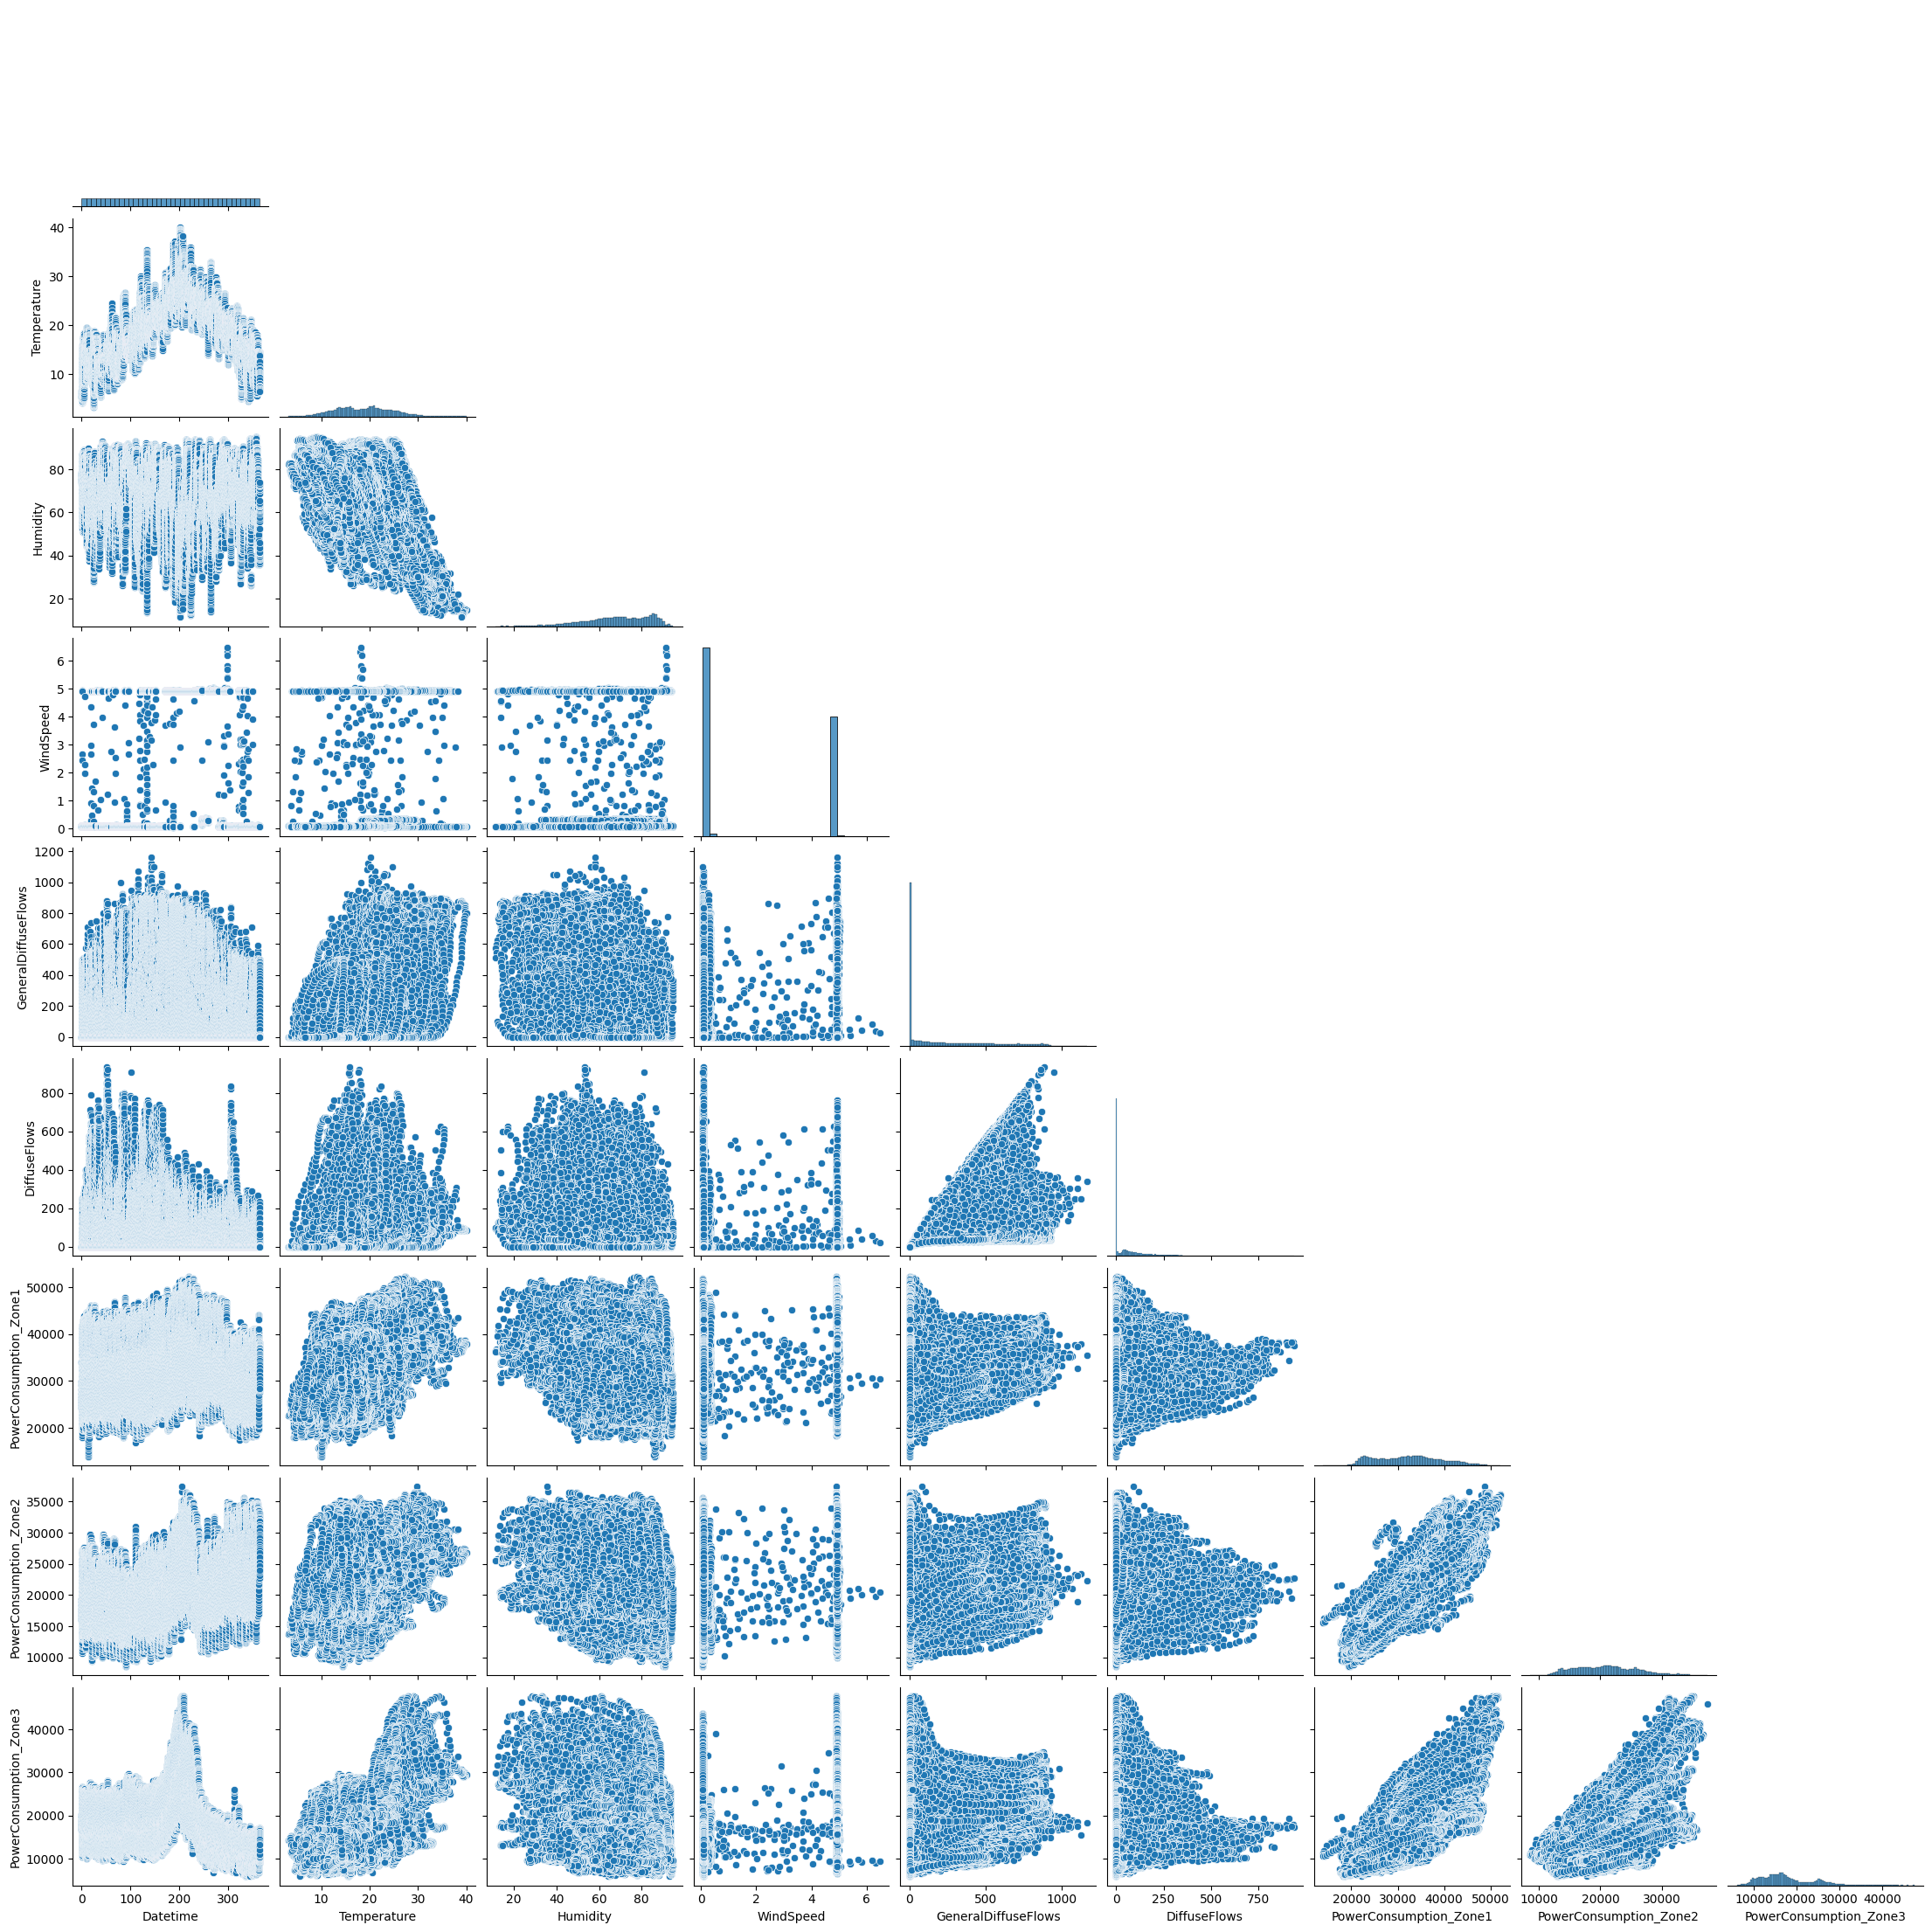

In [40]:
sns.pairplot(df, corner = True)
#=plt.savefig('figure/corner_plot_full.pdf', dpi = 200, bbox_inches = 'tight', pad_inches = 0.0)
plt.show()

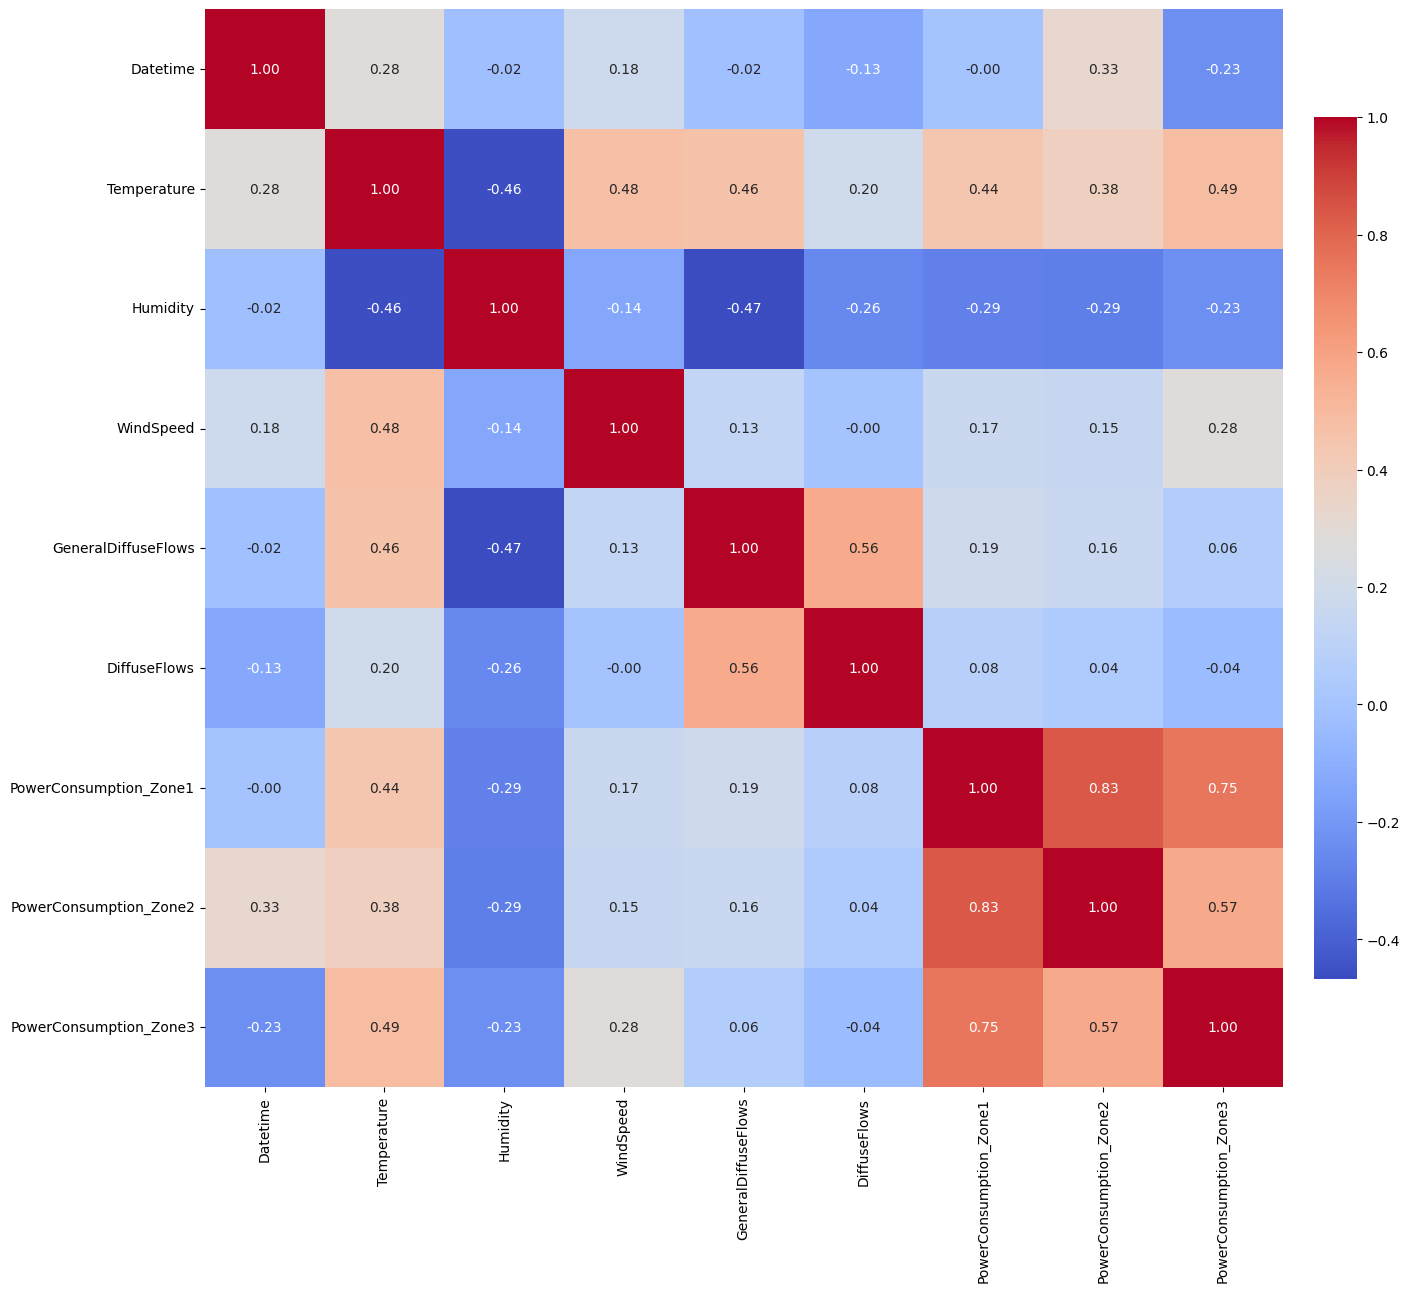

In [42]:
corr_matrix = df.corr()
plt.figure(figsize=(20, 14))
sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm', fmt='.2f', square = True, cbar_kws = {'shrink': 0.8, 'pad': 0.02})
#plt.savefig('figure/correlation_heatmap_full.pdf', dpi = 200, bbox_inches = 'tight', pad_inches = 0.0)
plt.show()

## Choosing time series of power consumptions only

In [43]:
df_ts = df[['Datetime', 'PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']]

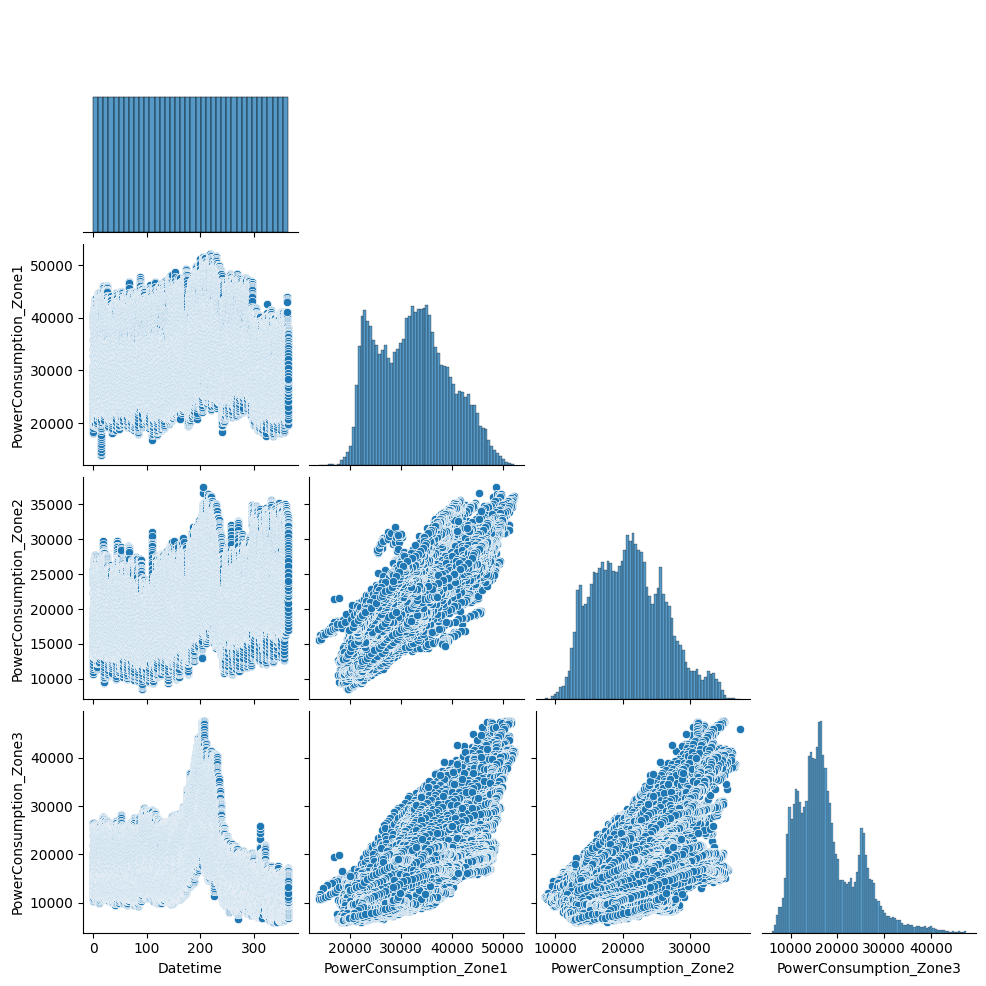

In [44]:
sns.pairplot(df_ts, corner = True)
#plt.savefig('figure/corner_plot_ts.pdf', dpi = 200, bbox_inches = 'tight', pad_inches = 0.0)
plt.show()

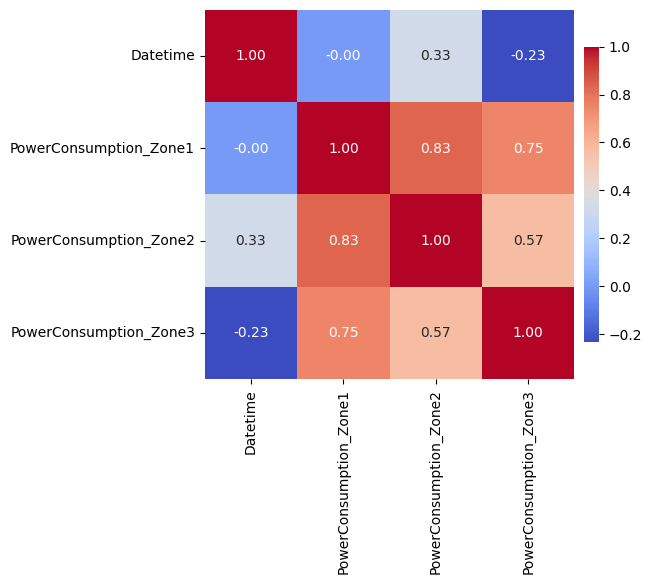

In [50]:
corr_matrix = df_ts.corr()
sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm', fmt='.2f', square = True, cbar_kws = {'shrink': 0.8, 'pad': 0.02})
#plt.savefig('figure/correlation_heatmap_ts.pdf', dpi = 200, bbox_inches = 'tight', pad_inches = 0.0)
plt.show()

In [260]:
def time_series_plot(data, t, zones, save = False, name = 'time_series_plot'):
    time = data[t]
    plt.figure(figsize = (12, 6 * len(zones) / 3), dpi = 200)
    for i, zone in enumerate(zones, start = 1):
        plt.subplot(len(zones), 1, i)
        plt.plot(time, data[zone], linewidth = 1)
        plt.xlim(min(time), max(time))
        #plt.ylim(4e3, 5.4e4)
        plt.ylabel(f'Zone {i}')
        plt.xlabel('Day' if i == len(zones) else '')
        plt.tight_layout()
        if save == True:
            plt.savefig(f'figure/{name}.pdf', dpi = 200, bbox_inches = 'tight', pad_inches = 0.0) 
    plt.show()

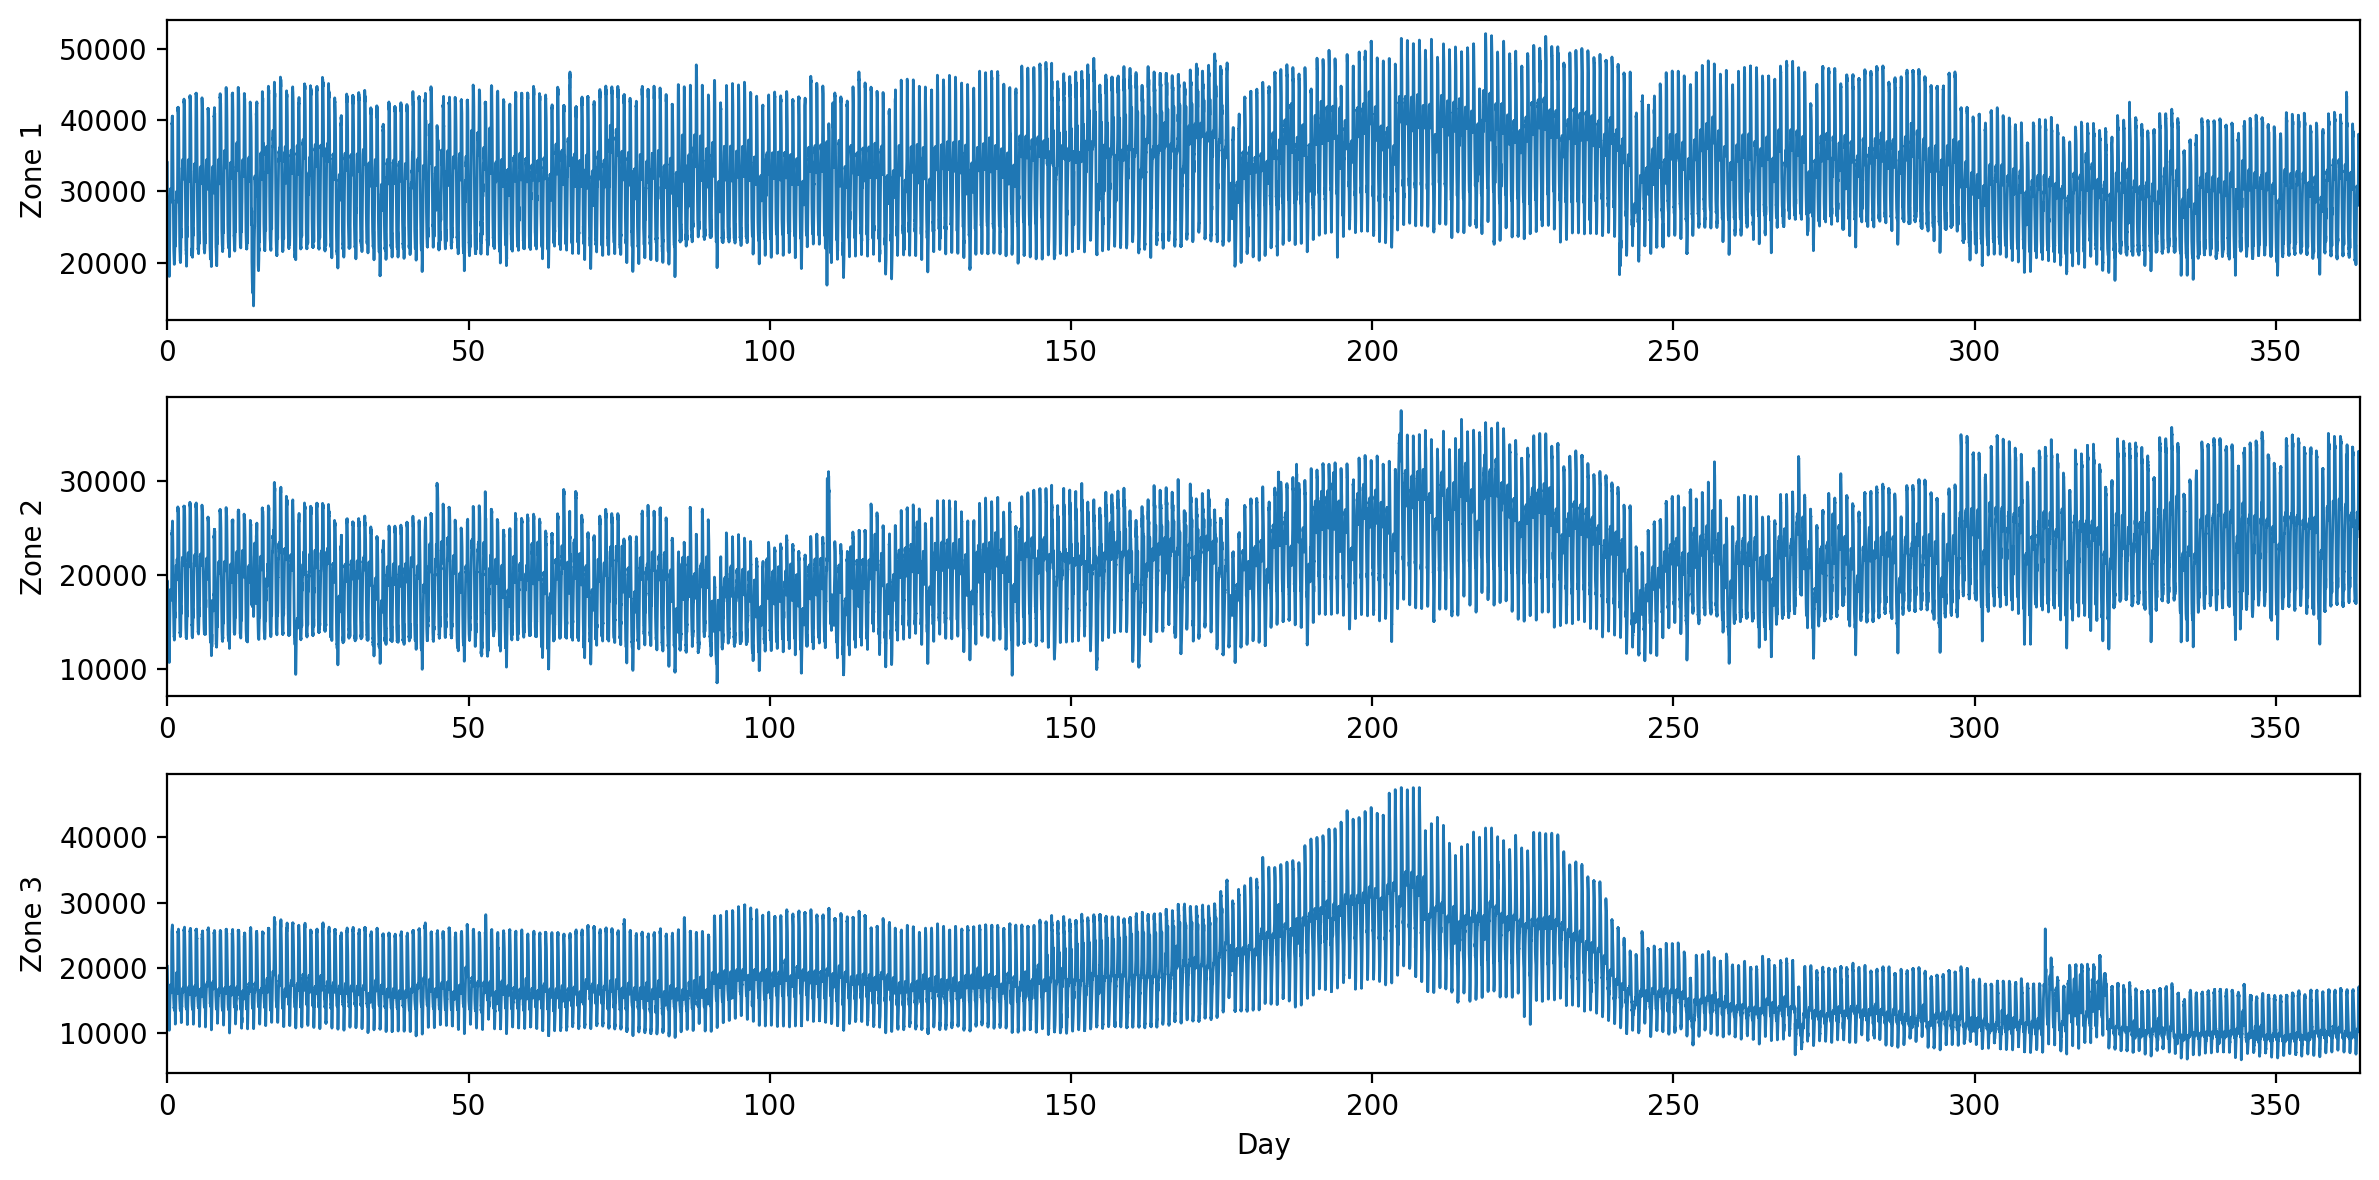

In [62]:
time_series_plot(df_ts, 
                 'Datetime', 
                 ['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3'],
                 save = False,
                 name = 'time_series_zones123_year')

In [68]:
i_day = 190 # choosing an index of the starting date
n = 24 * 6 # number of entries covering a single day, where 6 indicates an hour given 10-minute intervals in the dataset
df_day = df_ts[i_day: i_day + n]
df_2day = df_ts[i_day: i_day + 2*n]
df_week = df_ts[i_day: i_day + 7*n]
df_month = df_ts[i_day: i_day + 30*n]

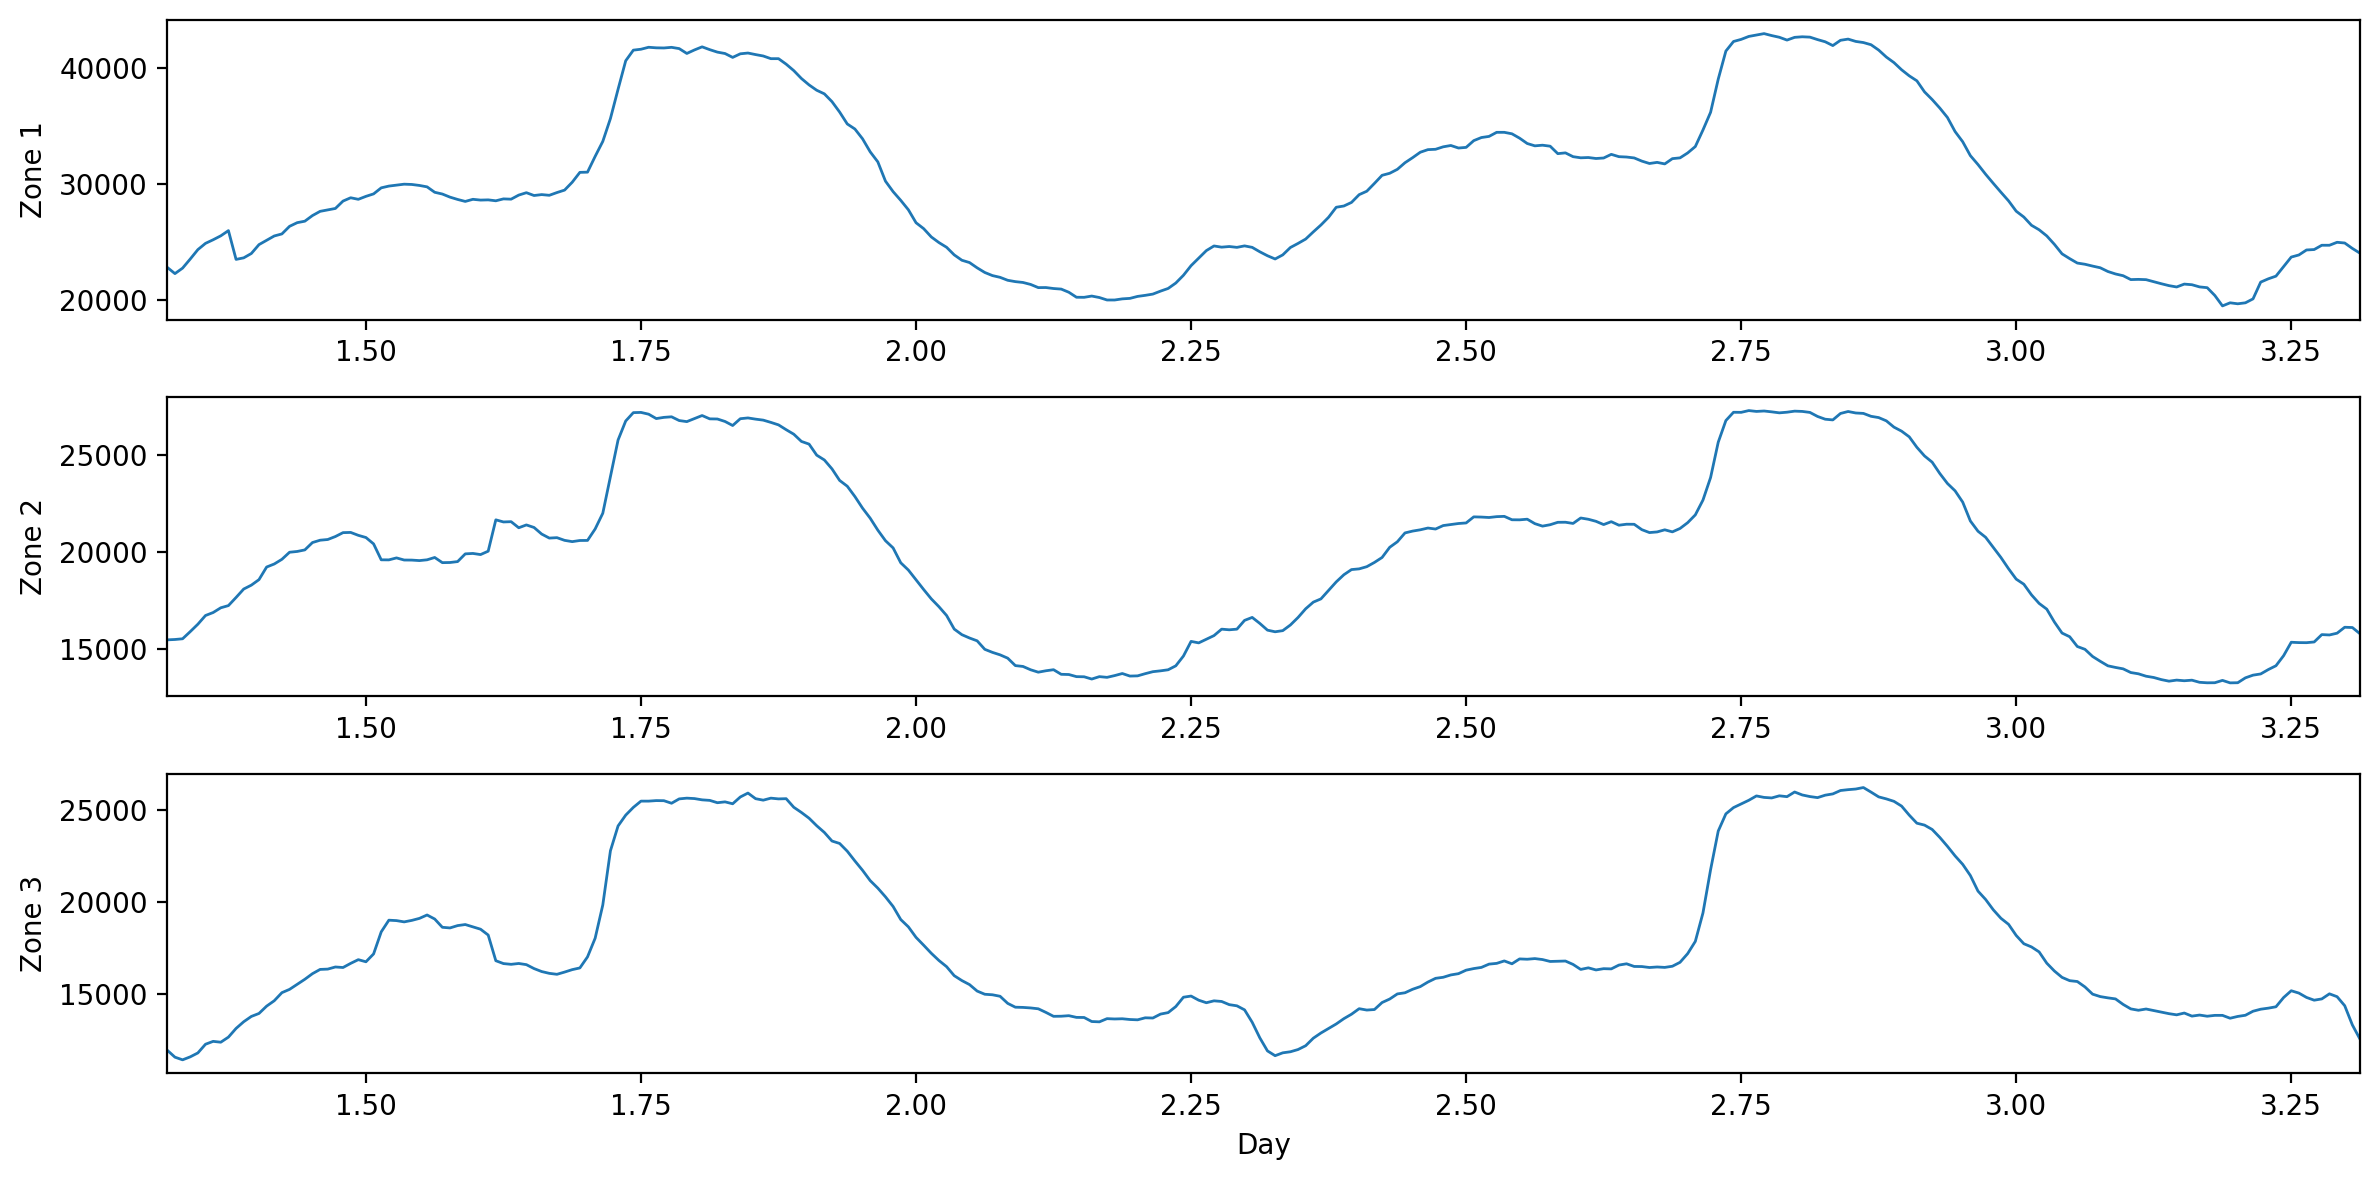

In [69]:
time_series_plot(df_2day,
                 'Datetime', 
                 ['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3'],
                 save = False,
                 name = 'time_series_zones123_day'
                )

# 2. Long-short term memory (LSTM) models

### Helper functions to prepare dataset for time-series analysis, split train-test sets, reshape for the models, and predict in the test set (yhat).

In [72]:
# create dataset for time-series models
def create_dataset(dataset, look_back = 1):
    data_size = len(dataset)
    x_data, y_data = [], []
    for i in range(data_size - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        x_data.append(a)
        y_data.append(dataset[i + look_back, 0])
    return np.array(x_data), np.array(y_data)

# prepare training and testing sets
def xy_train_test_sets(df, train_fraction = 0.7, look_back = 1, zone = 'PowerConsumption_Zone2'):
    # normalize the dataset
    scaler = MinMaxScaler(feature_range = (0, 1))
    df_scaled = scaler.fit_transform(df[[zone]])
    
    # split into train and test sets
    train_size = int(len(df_scaled) * train_fraction)
    test_size = len(df_scaled) - train_size
    train, test = df_scaled[0:train_size,:], df_scaled[train_size:len(df_scaled),:]
    
    # reshape into x = t and y = t + n_look_back
    look_back = 1
    x_train, y_train = create_dataset(train, look_back)
    x_test, y_test = create_dataset(test, look_back)
    x_train.shape, y_train.shape, x_test.shape, y_test.shape
    
    # reshape input to be [samples, time steps, features]
    x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
    x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
    
    return scaler, x_train, y_train, x_test, y_test

def yhat(model, x_train, x_test):
    # make predictions
    yhat_train = model.predict(x_train)
    yhat_test = model.predict(x_test)

    # inverse scalar transform to recover original feature space
    yhat_train_inv = scaler.inverse_transform(yhat_train)
    yhat_test_inv = scaler.inverse_transform(yhat_test)
    y_train_inv = scaler.inverse_transform([y_train])
    y_test_inv = scaler.inverse_transform([y_test])
    
    # calculate mean square errors
    MSE_train = np.sqrt(mean_squared_error(y_train_inv[0], yhat_train_inv[:,0]))
    MSE_test = np.sqrt(mean_squared_error(y_test_inv[0], yhat_test_inv[:,0]))
    print(f'Mean square error: {MSE_train} (train), {MSE_test} (test).')
    
    return yhat_test_inv

### Helper functions to plot figures.

In [325]:
# plot the actual and forecast time series, and the absolute and relative errors (i.e., forecast - actual)
def forecast_plot(yhat_test_inv, df, history, epochs, zone = 'PowerConsumption_Zone2', save = False, name = 'forecast'):
    # indices for plots
    #time_index_train = np.array(df.index - i_day)[:len(yhat_train_inv)] + look_back
    time_index_test = np.array(df.index - i_day)[-len(yhat_test_inv):]
    
    # difference between prediction and actual
    diff_yhat_test = yhat_test_inv.flatten() - np.array(df[zone][-len(yhat_test_inv):])
    diff_yhat_test_frac = diff_yhat_test/np.array(df[zone][-len(yhat_test_inv):])

    fig = plt.figure(figsize = (24, 14), dpi = 200)
    
    # plot actual and predicted values over time
    plt.subplot(221)
    plt.plot(df.index - i_day, df[zone], 'lightgreen', label = 'Actual')
    #plt.plot(time_index_train, y_train_inv[0], c = 'darkorange', ls = '--', label = 'Training')
    #plt.plot(time_index_train, yhat_train_inv, label = 'Forecast (train)')
    plt.plot(time_index_test, yhat_test_inv, 'darkblue', label = 'Forecast')
    plt.xlabel('Datetime index', fontsize = 25)
    plt.ylabel('Power consumption', fontsize = 25)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.legend(fontsize = 20)
    
    # plot model performance (loss and MAE) over epochs
    plt.subplot(222)
    epoch_plot = np.arange(1, epochs + 1)
    epoch_tick = np.arange(0, epochs, 4)
    plt.plot(epoch_plot, history.history['loss'], 'darkorange', ls = '--', label='Training loss')
    plt.plot(epoch_plot, history.history['val_loss'], 'darkorange', ls = '-', label='Validation loss')
    plt.plot(epoch_plot, history.history['mae'], 'gray', ls = '--', label='Training MAE')
    plt.plot(epoch_plot, history.history['val_mae'], 'gray', ls = '-', label='Validation MAE')
    plt.legend(fontsize = 20)
    plt.xlabel('Epoch', fontsize = 25)
    plt.ylabel('Model performance measures', fontsize = 25)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    
    # plot forecast error (absolute and relative)
    plt.subplot(223)
    plt.plot(time_index_test, diff_yhat_test, color = 'crimson', label='LSTM')
    plt.xlabel('Datetime index', fontsize = 25)
    plt.ylabel('Absolute forecast error', fontsize = 25)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    
    # plot forecast error distribution (histogram)
    plt.subplot(224)
    plt.hist(diff_yhat_test_frac, bins = 20, 
             weights = np.zeros_like(diff_yhat_test_frac) + 1. / diff_yhat_test_frac.size,
             facecolor = 'skyblue', edgecolor = 'black', 
             label = r'Mean: ${:.2f}$.'.format(np.mean(diff_yhat_test_frac)))
    plt.plot([], [], color = 'white', label = r'Min: ${:.2f}$.'.format(min(diff_yhat_test_frac)))
    plt.plot([], [], color = 'white', label = r'Max: ${:.2f}$.'.format(max(diff_yhat_test_frac)))
    plt.legend(fontsize = 20)
    plt.xlabel('Relative forecast error', fontsize = 25)
    plt.ylabel('Frequency count', fontsize = 25)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    
    plt.tight_layout()
    
    if save == True:
        plt.savefig(f'figure/{name}.pdf', dpi = 200, bbox_inches = 'tight', pad_inches = 0.0)
    plt.show()

### Fix a zone etc.

In [314]:
# fix randomness
tf.random.set_seed(42)
# pick zone2 (could be any zone)
zone = 'PowerConsumption_Zone2'

## 2.1 Time series (1 day)

In [415]:
scaler, x_train, y_train, x_test, y_test = xy_train_test_sets(df = df_day) # get transform scalar, train and test datasets
look_back = 1 # look-back time step

model = Sequential()
model.add(LSTM(units = 50, return_sequences = True, input_shape = (look_back, 1))) # shape = (timesteps, features)
model.add(Dropout(rate = 0.1))
model.add(Dense(units = 50))
model.add(Dropout(rate = 0.1))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dense(units = 10))
model.add(Dropout(rate = 0.1))
model.add(LSTM(units = 50, return_sequences = False))
model.add(Dropout(rate = 0.1))
model.add(Dense(units = 50, activation = 'relu'))
model.add(Dense(units = 50))
model.add(Dense(units = 1, activation = 'relu'))
model.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'mean_squared_error', metrics = ['mae'])
#model.compile(optimizer = SGD(learning_rate = 0.001), loss = 'mean_squared_error', metrics = ['mae'])
model.summary()

epochs = 300
batch_size = 16
history = model.fit(x_train, y_train, epochs = epochs, batch_size = batch_size, validation_data = (x_test, y_test), verbose = 0)

Model: "sequential_67"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_192 (LSTM)                 │ (None, 1, 50)          │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_257 (Dense)               │ (None, 1, 50)          │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_193 (LSTM)                 │ (None, 1, 50)          │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_258 (Dense)               │ (None, 1, 10)          │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_65 (Dropout)            │ (None, 1, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_194 (LSTM)                 │ (None, 50)             │        12,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_66 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_259 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_260 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_261 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,011 (199.26 KB)

 Trainable params: 51,011 (199.26 KB)

 Non-trainable params: 0 (0.00 B)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step
Mean square error: 383.2317242292817 (train), 466.00993974493235 (test).


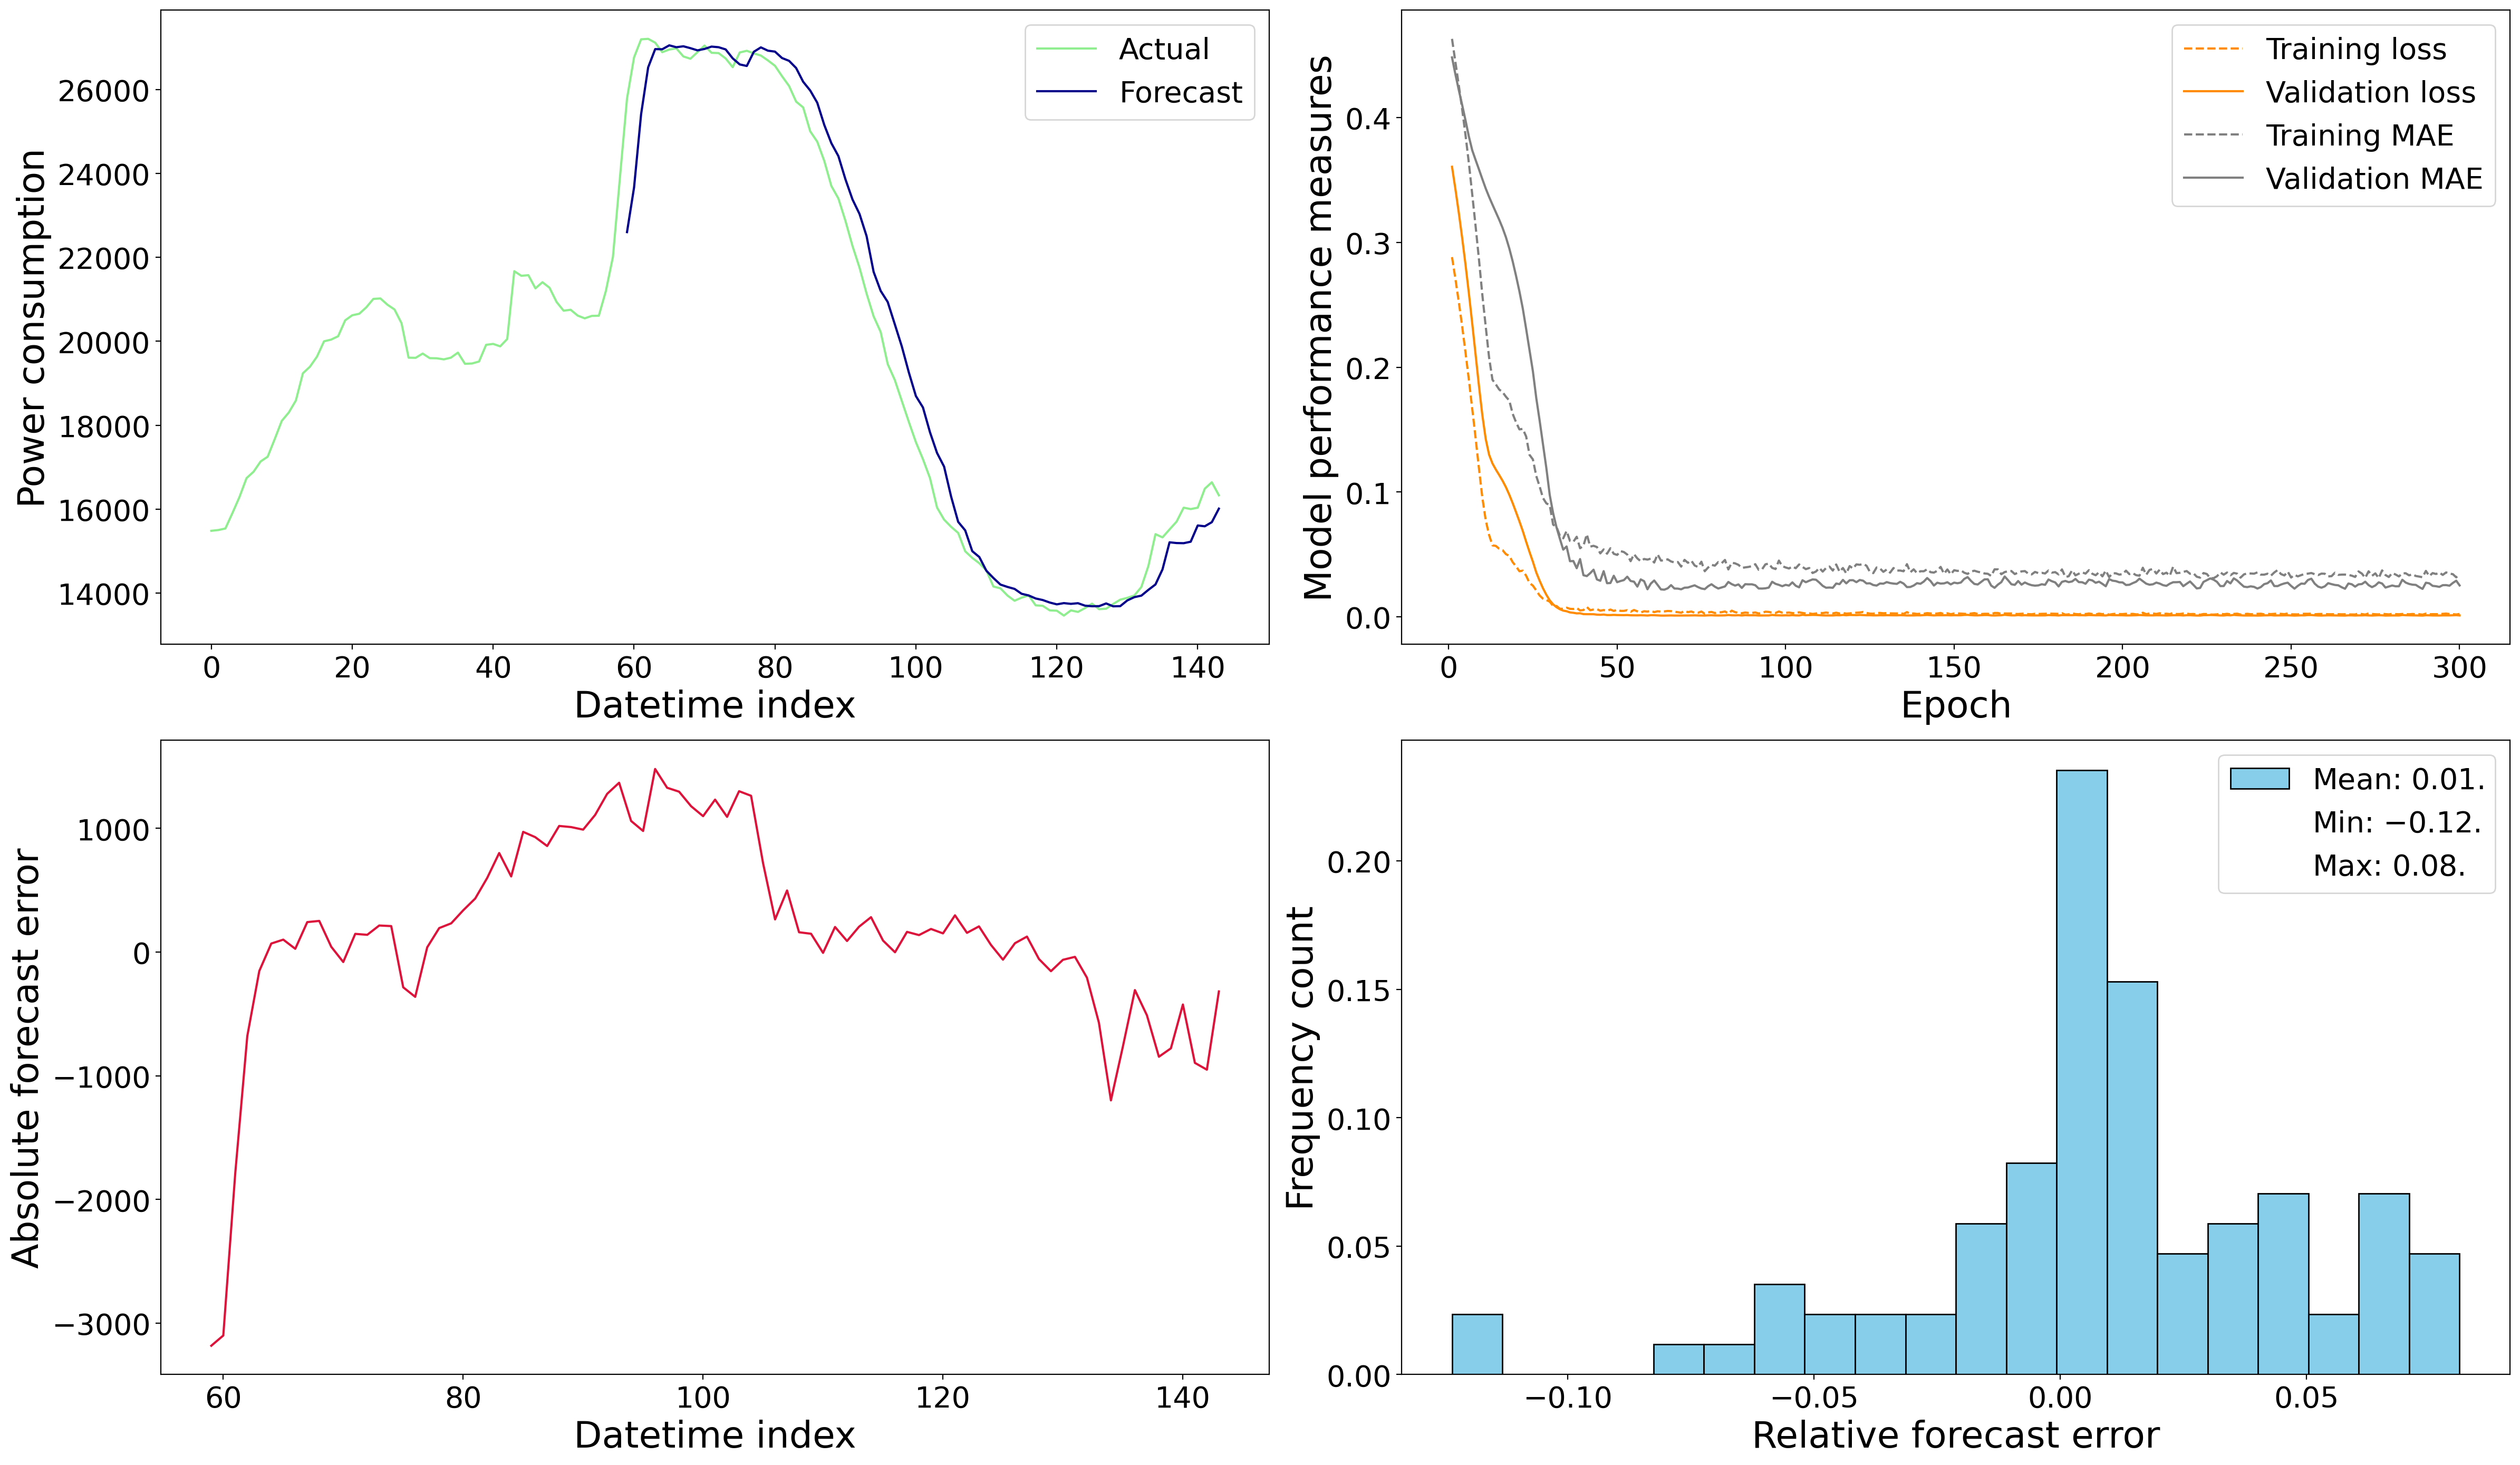

In [418]:
yhat_test_inv = yhat(model, x_train, x_test)
forecast_plot(yhat_test_inv, df_day, history, epochs, 
              save = False,
              name = 'pred_day_nt1_ep300_batch16_lstm3_50_dense4_50_drop4_1_lr1e_4_relu')

## 2.2 Time series (2 days)

In [438]:
scaler, x_train, y_train, x_test, y_test = xy_train_test_sets(df = df_2day) # get transform scalar, train and test datasets
look_back = 2 # look-back time step

model = Sequential()
model.add(LSTM(units = 50, return_sequences = True, input_shape = (look_back, 1))) # shape = (timesteps, features)
model.add(Dropout(rate = 0.1))
model.add(Dense(units = 50))
model.add(Dropout(rate = 0.1))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dense(units = 10))
model.add(Dropout(rate = 0.1))
model.add(LSTM(units = 50, return_sequences = False))
model.add(Dropout(rate = 0.1))
model.add(Dense(units = 50, activation = 'relu'))
model.add(Dense(units = 50))
model.add(Dense(units = 1, activation = 'relu'))
model.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'mean_squared_error', metrics = ['mae'])
#model.compile(optimizer = SGD(learning_rate = 0.001), loss = 'mean_squared_error', metrics = ['mae'])
model.summary()

epochs = 300
batch_size = 32
history = model.fit(x_train, y_train, epochs = epochs, batch_size = batch_size, validation_data = (x_test, y_test), verbose = 0)

Model: "sequential_76"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_219 (LSTM)                 │ (None, 2, 50)          │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_99 (Dropout)            │ (None, 2, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_302 (Dense)               │ (None, 2, 50)          │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_100 (Dropout)           │ (None, 2, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_220 (LSTM)                 │ (None, 2, 50)          │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_303 (Dense)               │ (None, 2, 10)          │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_101 (Dropout)           │ (None, 2, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_221 (LSTM)                 │ (None, 50)             │        12,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_102 (Dropout)           │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_304 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_305 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_306 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,011 (199.26 KB)

 Trainable params: 51,011 (199.26 KB)

 Non-trainable params: 0 (0.00 B)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step
Mean square error: 390.7948508994936 (train), 452.37788012583485 (test).


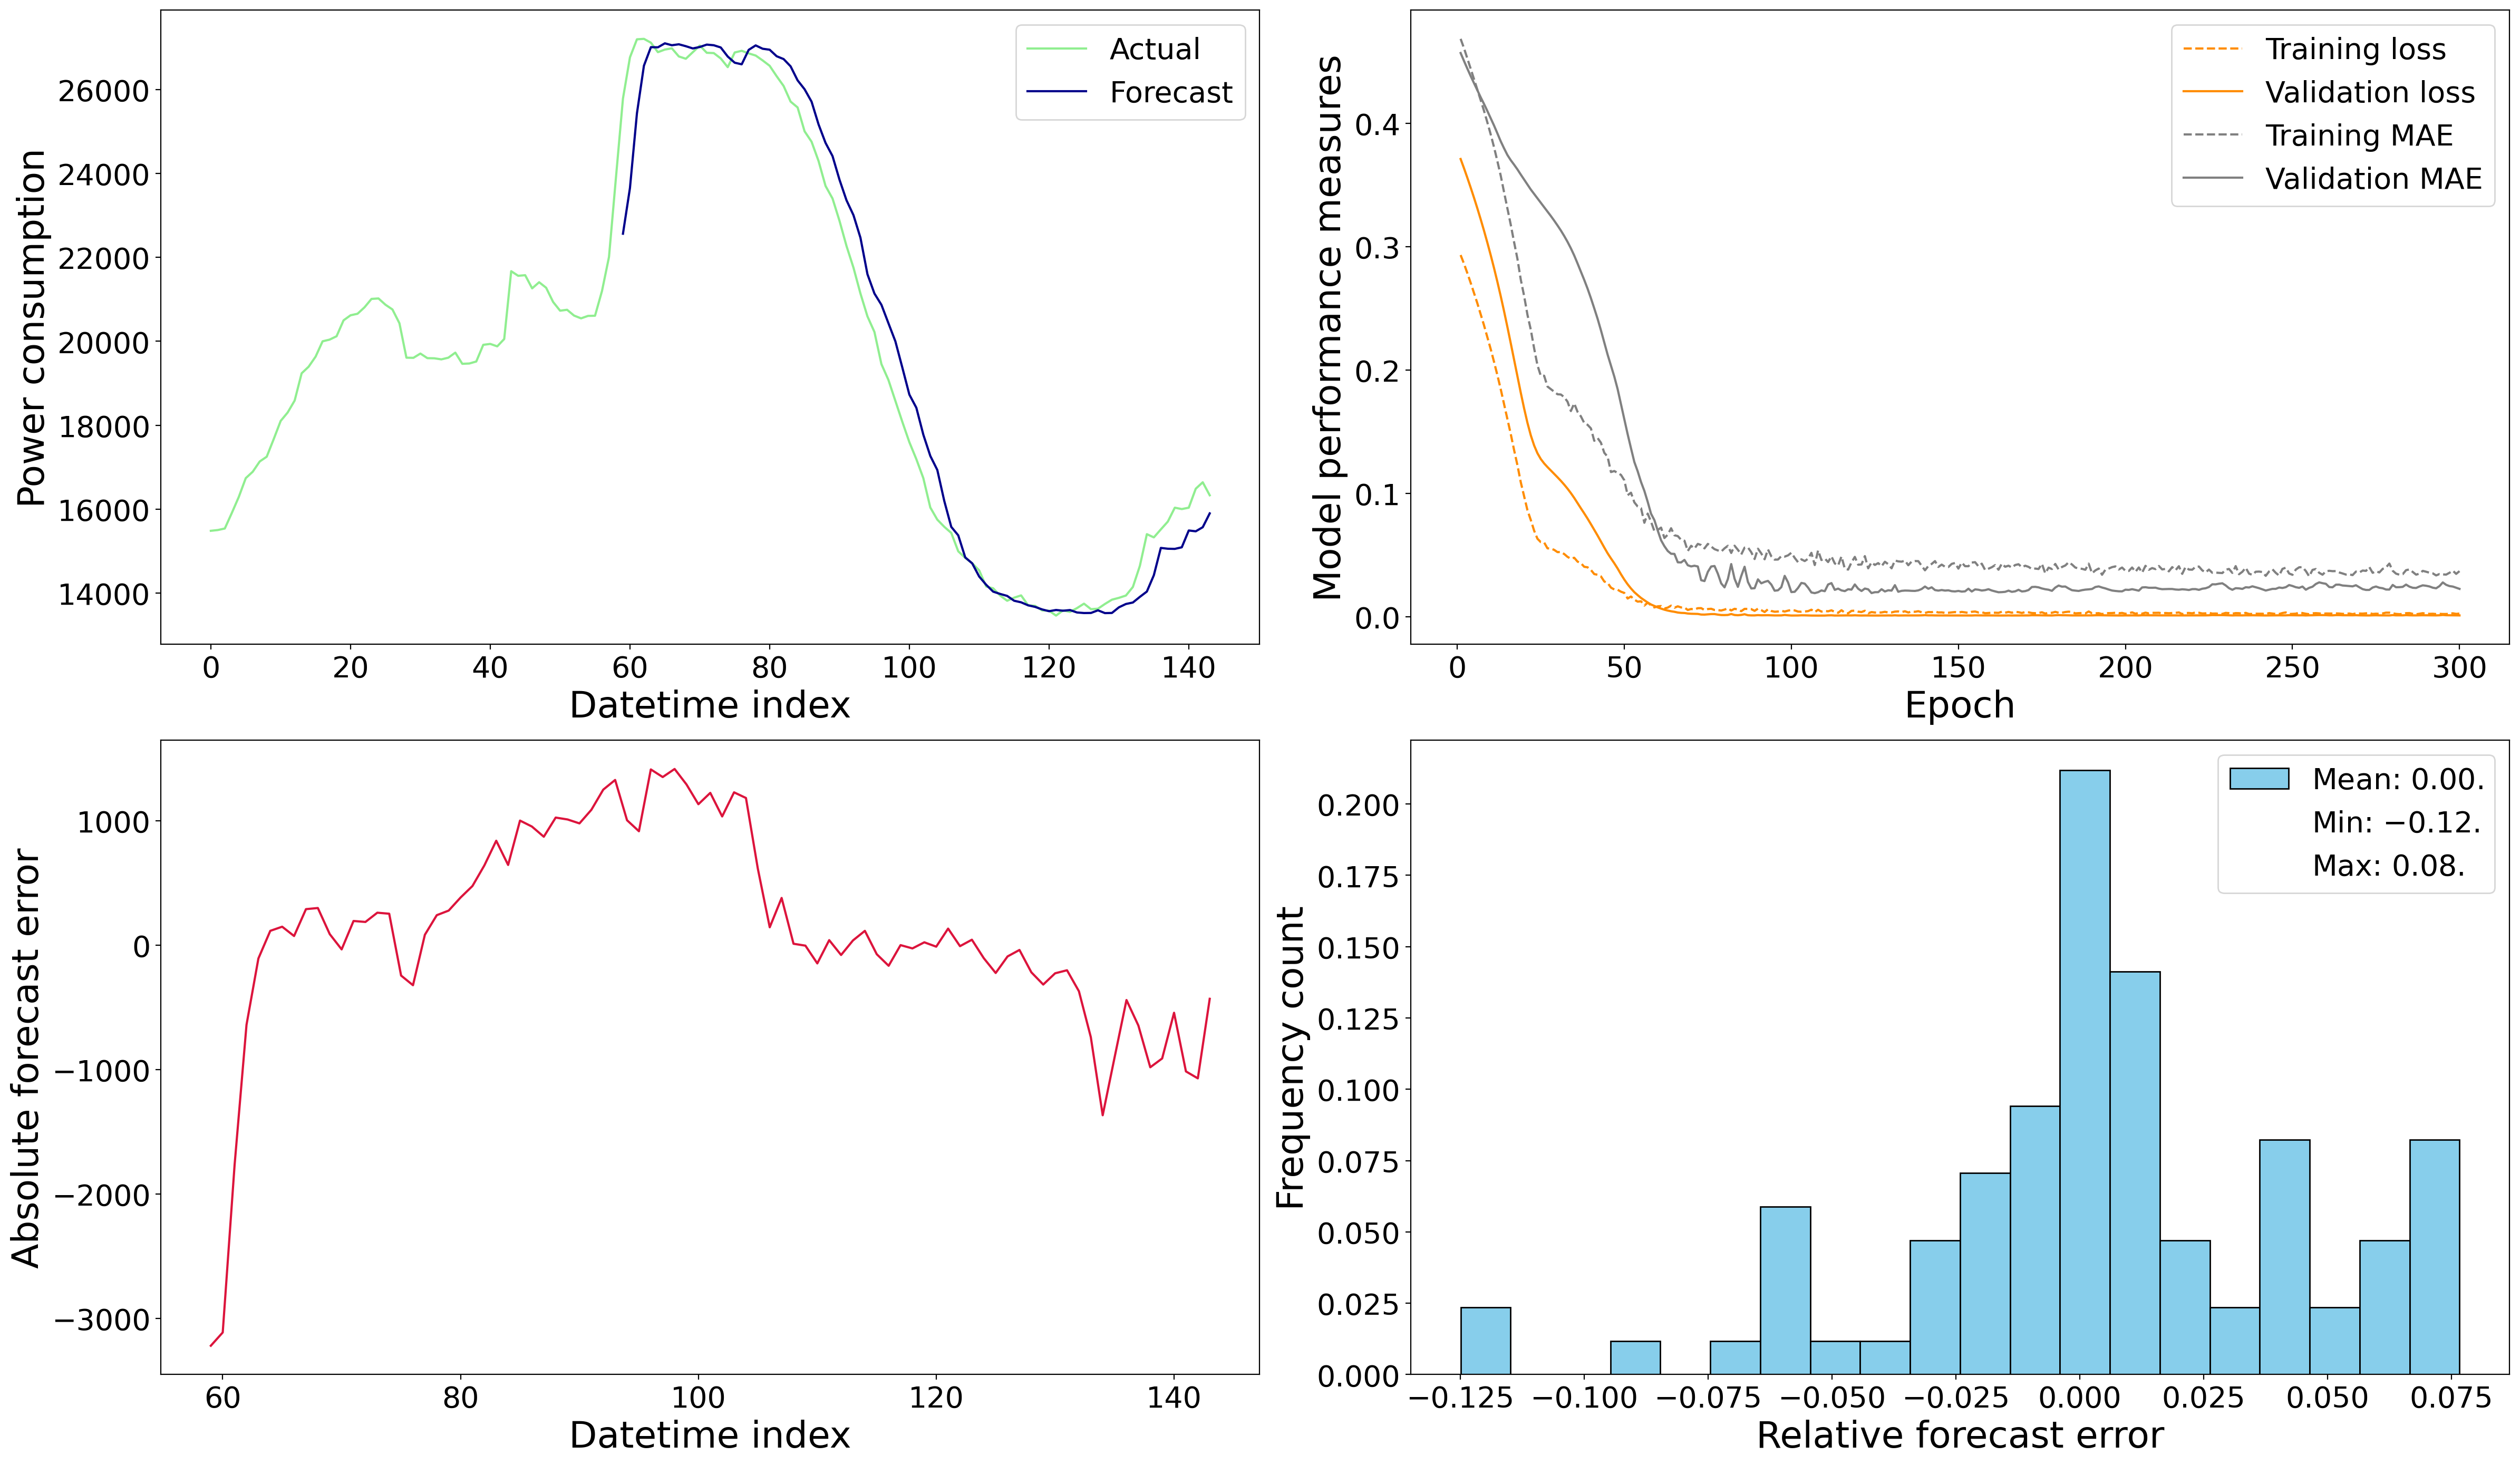

In [441]:
yhat_test_inv = yhat(model, x_train, x_test)
forecast_plot(yhat_test_inv, df_day, history, epochs, 
              save = False,
              name = 'pred_2day_nt2_ep300_batch32_lstm3_50_dense4_50_drop4_1_lr1e_4_relu')

## 2.3 Time series (1 week)

In [492]:
scaler, x_train, y_train, x_test, y_test = xy_train_test_sets(df = df_week)
look_back = 2 # look-back time step

model = Sequential()
model.add(LSTM(units = 60, return_sequences = True, input_shape = (look_back, 1))) # shape = (timesteps, features)
model.add(Dense(units = 50, activation = 'relu'))
#model.add(LSTM(units = 60, return_sequences = True))
#model.add(Dropout(rate = 0.1))
#model.add(Dense(units = 50, activation = 'relu'))
model.add(LSTM(units = 60, return_sequences = True))
#model.add(Dropout(rate = 0.1))
model.add(Dense(units = 50, activation = 'relu'))
#model.add(Dropout(rate = 0.1))
model.add(LSTM(units = 60, return_sequences = False))
#model.add(Dropout(rate = 0.1))
model.add(Dense(units = 50, activation = 'relu'))
#model.add(Dropout(rate = 0.1))
model.add(Dense(units = 50))
model.add(Dense(units = 1, activation = 'relu'))
model.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'mean_squared_error', metrics = ['mae'])
#model.compile(optimizer = SGD(learning_rate = 0.001), loss = 'mean_squared_error', metrics = ['mae'])
model.summary()

epochs = 200
batch_size = 64
history = model.fit(x_train, y_train, epochs = epochs, batch_size = batch_size, validation_data = (x_test, y_test), verbose = 0)

Model: "sequential_102"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_311 (LSTM)                 │ (None, 2, 60)          │        14,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_420 (Dense)               │ (None, 2, 50)          │         3,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_312 (LSTM)                 │ (None, 2, 60)          │        26,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_421 (Dense)               │ (None, 2, 50)          │         3,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_313 (LSTM)                 │ (None, 60)             │        26,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_422 (Dense)               │ (None, 50)             │         3,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_423 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_424 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,911 (312.15 KB)

 Trainable params: 79,911 (312.15 KB)

 Non-trainable params: 0 (0.00 B)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
Mean square error: 375.07613292525036 (train), 419.11334049193744 (test).


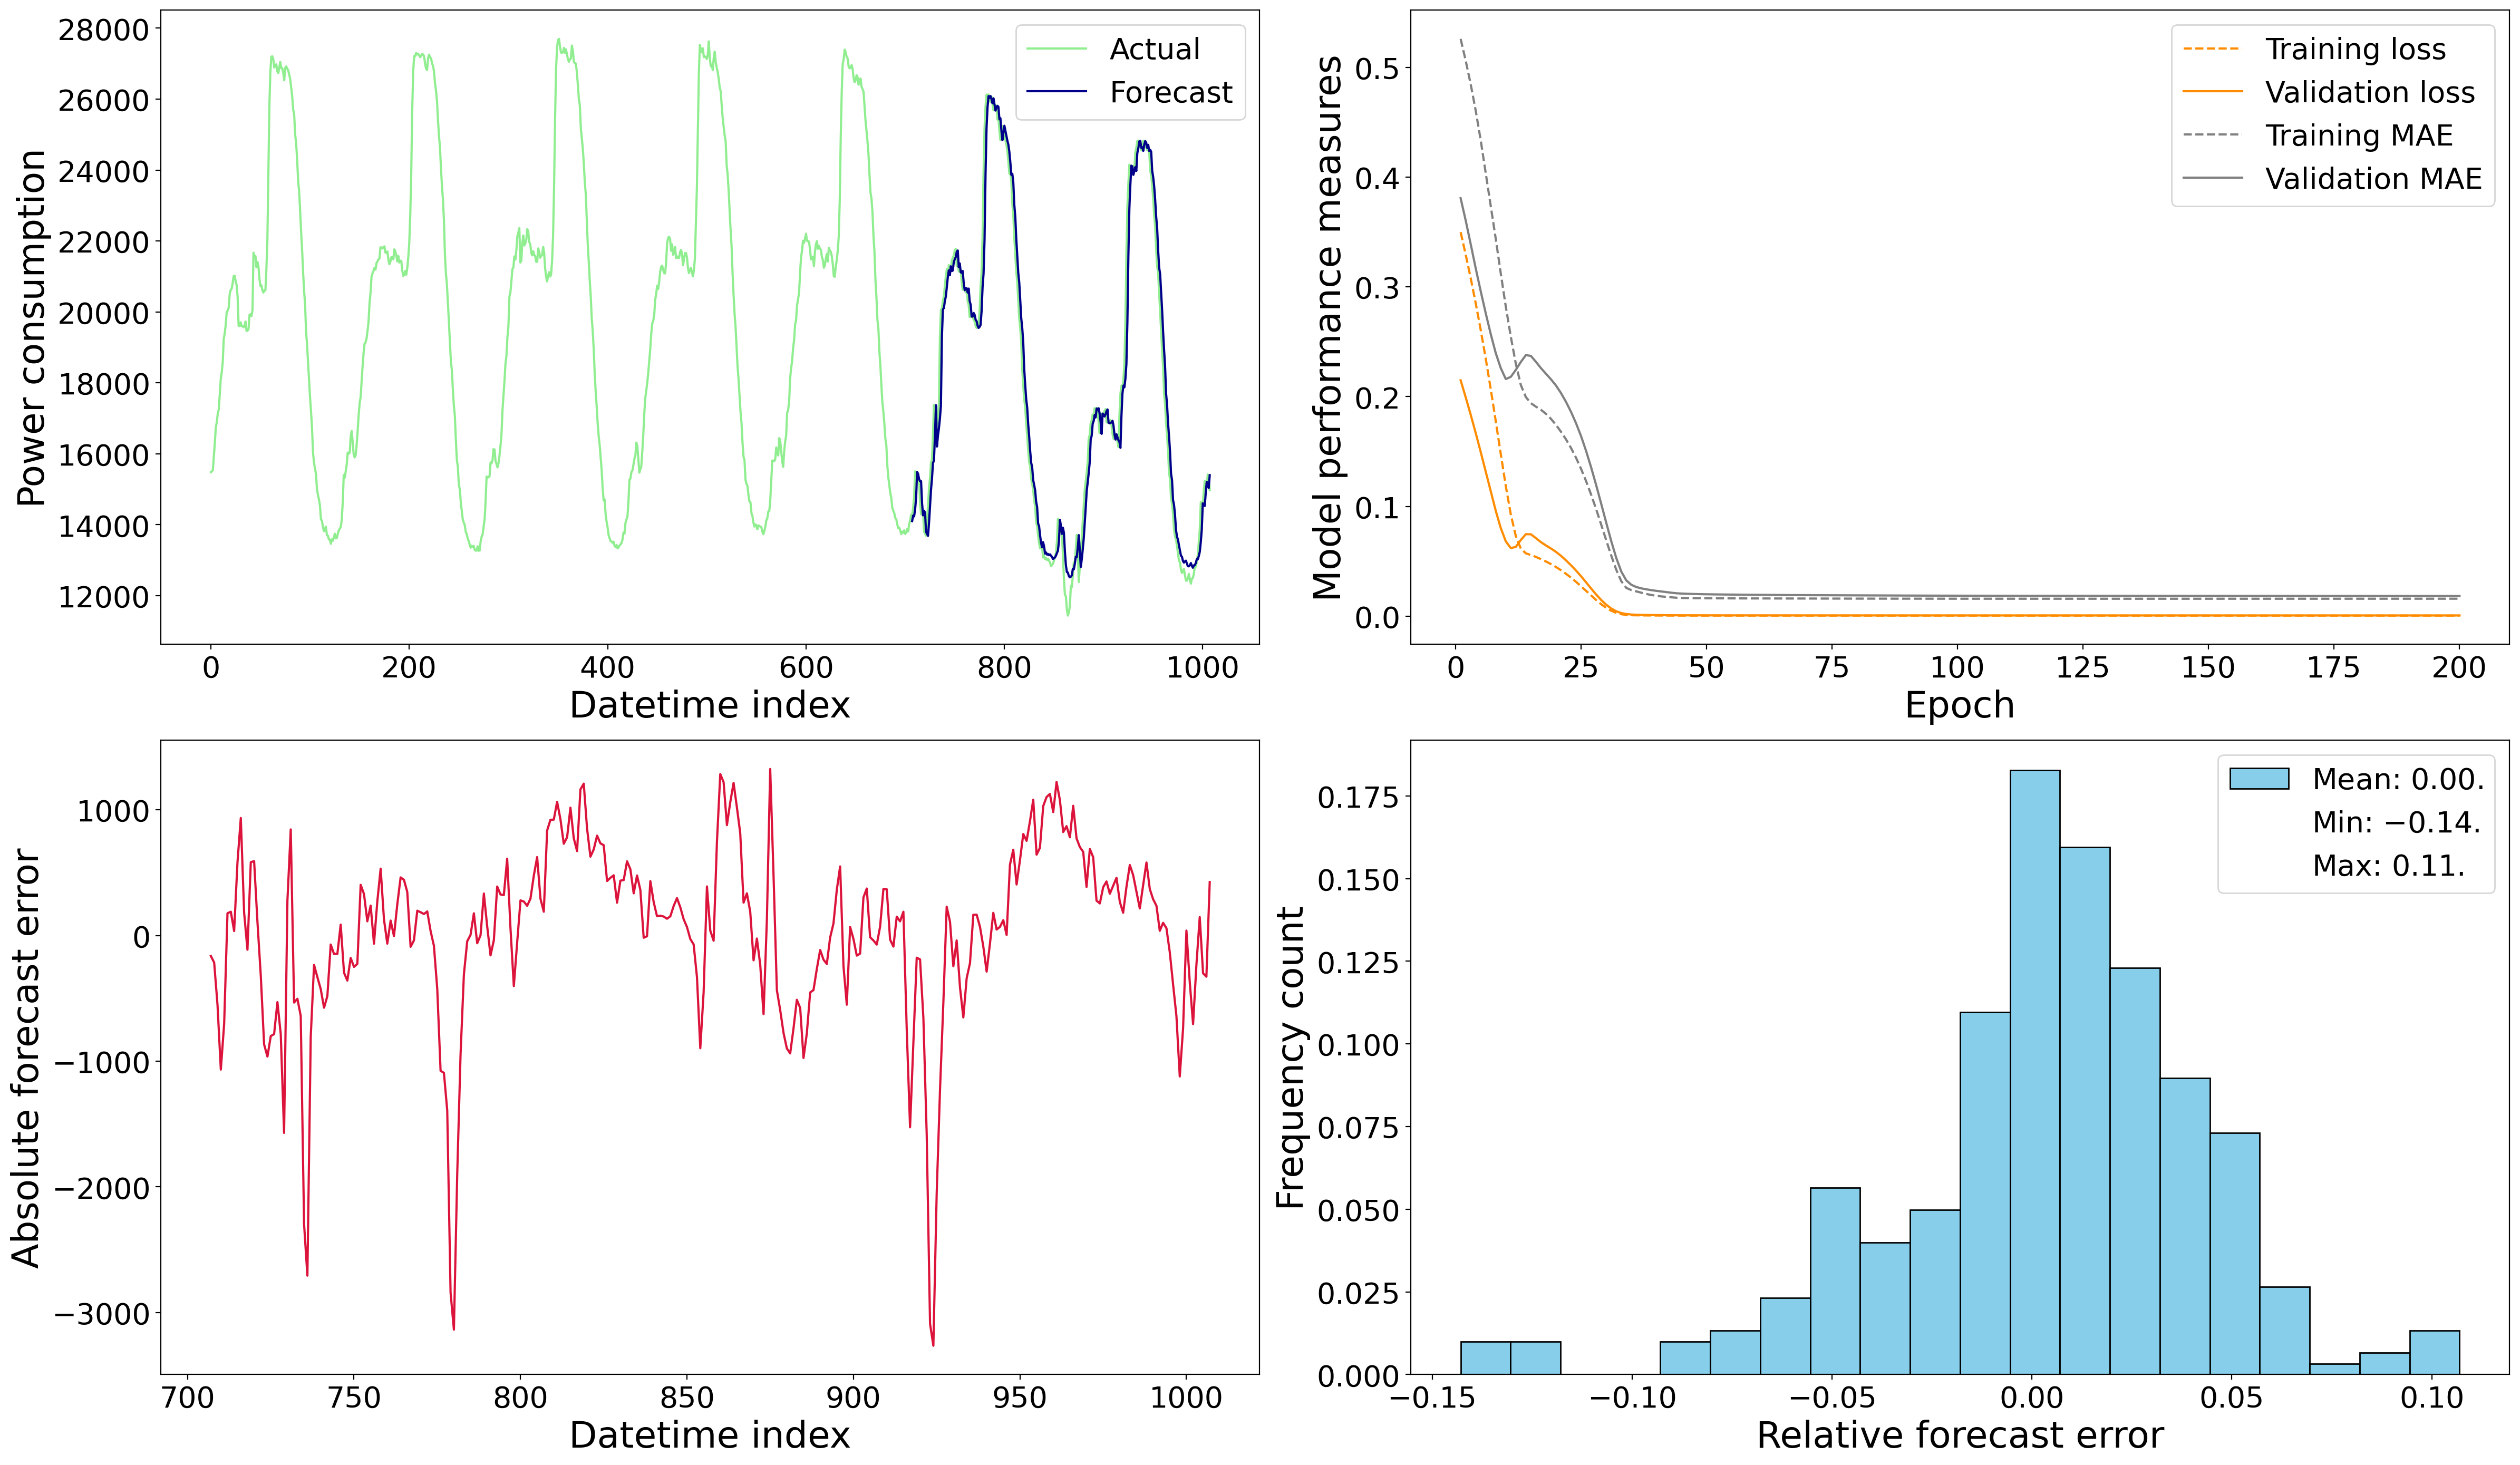

In [495]:
yhat_test_inv = yhat(model, x_train, x_test)
forecast_plot(yhat_test_inv, df_week, history, epochs, 
              save = False,
              name = 'pred_week_ep200_batch64_lstm3_dense4_drop0_lr1e_4_relu')

## 2.4 Time series (1 month)

In [517]:
scaler, x_train, y_train, x_test, y_test = xy_train_test_sets(df = df_month)
look_back = 30 # look-back time step

model = Sequential()
model.add(LSTM(units = 60, return_sequences = True, input_shape = (look_back, 1))) # shape = (timesteps, features)
model.add(Dense(units = 50, activation = 'relu'))
model.add(LSTM(units = 60, return_sequences = True))
model.add(Dropout(rate = 0.1))
model.add(Dense(units = 50, activation = 'relu'))
model.add(LSTM(units = 60, return_sequences = True))
#model.add(Dropout(rate = 0.1))
model.add(Dense(units = 50, activation = 'relu'))
#model.add(Dropout(rate = 0.1))
model.add(LSTM(units = 60, return_sequences = False))
#model.add(Dropout(rate = 0.1))
model.add(Dense(units = 50, activation = 'relu'))
model.add(Dropout(rate = 0.1))
model.add(Dense(units = 50))
model.add(Dense(units = 1, activation = 'relu'))
model.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'mean_squared_error', metrics = ['mae'])
#model.compile(optimizer = SGD(learning_rate = 0.001), loss = 'mean_squared_error', metrics = ['mae'])
model.summary()

epochs = 50
batch_size = 8
history = model.fit(x_train, y_train, epochs = epochs, batch_size = batch_size, validation_data = (x_test, y_test), verbose = 0)

Model: "sequential_113"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_352 (LSTM)                 │ (None, 30, 60)         │        14,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_481 (Dense)               │ (None, 30, 50)         │         3,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_353 (LSTM)                 │ (None, 30, 60)         │        26,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_211 (Dropout)           │ (None, 30, 60)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_482 (Dense)               │ (None, 30, 50)         │         3,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_354 (LSTM)                 │ (None, 30, 60)         │        26,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_483 (Dense)               │ (None, 30, 50)         │         3,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_355 (LSTM)                 │ (None, 60)             │        26,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_484 (Dense)               │ (None, 50)             │         3,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_212 (Dropout)           │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_485 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_486 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,601 (428.13 KB)

 Trainable params: 109,601 (428.13 KB)

 Non-trainable params: 0 (0.00 B)

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step
Mean square error: 444.75850288689855 (train), 424.6952351083892 (test).


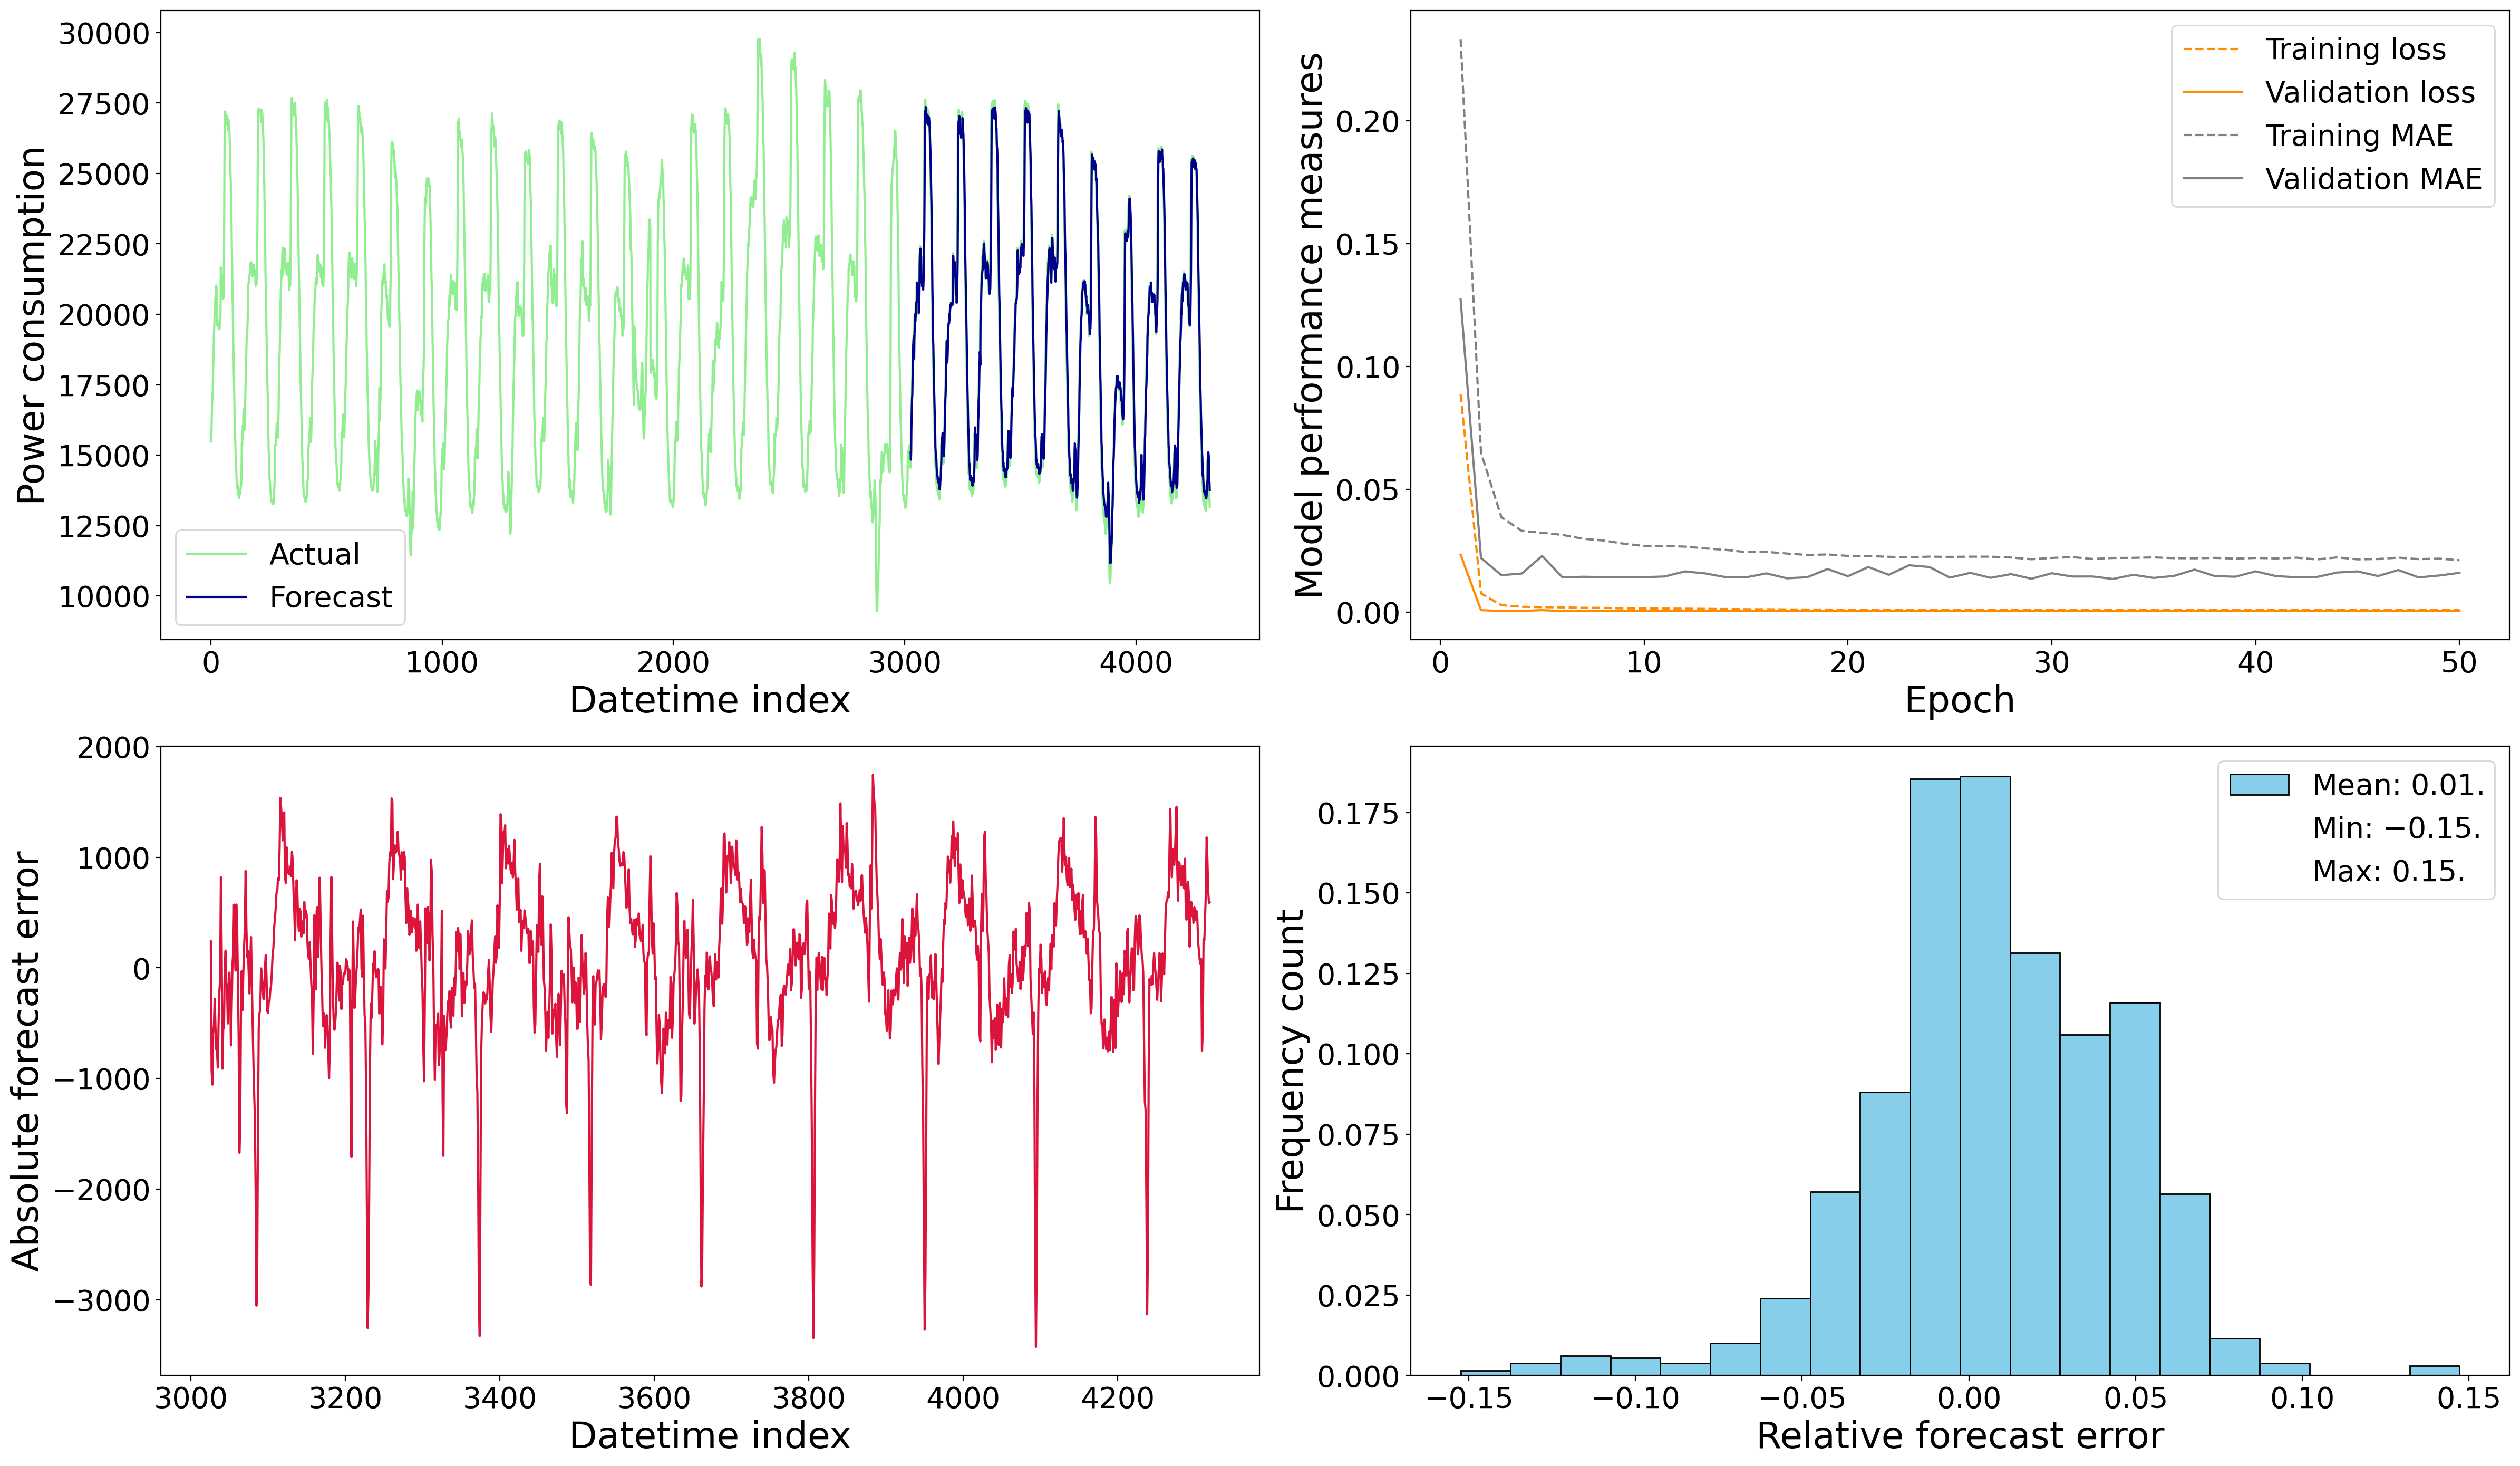

In [520]:
yhat_test_inv = yhat(model, x_train, x_test)
forecast_plot(yhat_test_inv, df_month, history, epochs, 
              save = False,
              name = 'pred_month_ep50_batch8_lstm4_dense5_drop2_lr1e_4')

## 2.5 Time series (1 year)

In [527]:
scaler, x_train, y_train, x_test, y_test = xy_train_test_sets(df = df_ts)
look_back = 1 # look-back time step

model = Sequential()
model.add(LSTM(units = 60, return_sequences = True, input_shape = (look_back, 1))) # shape = (timesteps, features)
model.add(Dense(units = 50, activation = 'relu'))
model.add(LSTM(units = 60, return_sequences = True))
model.add(Dropout(rate = 0.1))
model.add(Dense(units = 50, activation = 'relu'))
model.add(LSTM(units = 60, return_sequences = True))
#model.add(Dropout(rate = 0.1))
model.add(Dense(units = 50, activation = 'relu'))
#model.add(Dropout(rate = 0.1))
model.add(LSTM(units = 60, return_sequences = False))
#model.add(Dropout(rate = 0.1))
model.add(Dense(units = 50, activation = 'relu'))
model.add(Dropout(rate = 0.1))
model.add(Dense(units = 50))
model.add(Dense(units = 1, activation = 'relu'))
model.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'mean_squared_error', metrics = ['mae'])
#model.compile(optimizer = SGD(learning_rate = 0.001), loss = 'mean_squared_error', metrics = ['mae'])
model.summary()

epochs = 50
batch_size = 128
history = model.fit(x_train, y_train, epochs = epochs, batch_size = batch_size, validation_data = (x_test, y_test), verbose = 0)

Model: "sequential_117"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_367 (LSTM)                 │ (None, 1, 60)          │        14,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_503 (Dense)               │ (None, 1, 50)          │         3,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_368 (LSTM)                 │ (None, 1, 60)          │        26,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_217 (Dropout)           │ (None, 1, 60)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_504 (Dense)               │ (None, 1, 50)          │         3,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_369 (LSTM)                 │ (None, 1, 60)          │        26,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_505 (Dense)               │ (None, 1, 50)          │         3,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_370 (LSTM)                 │ (None, 60)             │        26,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_506 (Dense)               │ (None, 50)             │         3,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_218 (Dropout)           │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_507 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_508 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,601 (428.13 KB)

 Trainable params: 109,601 (428.13 KB)

 Non-trainable params: 0 (0.00 B)

1147/1147 ━━━━━━━━━━━━━━━━━━━━ 1s 526us/step
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step
Mean square error: 420.36464874914554 (train), 446.35561263438524 (test).


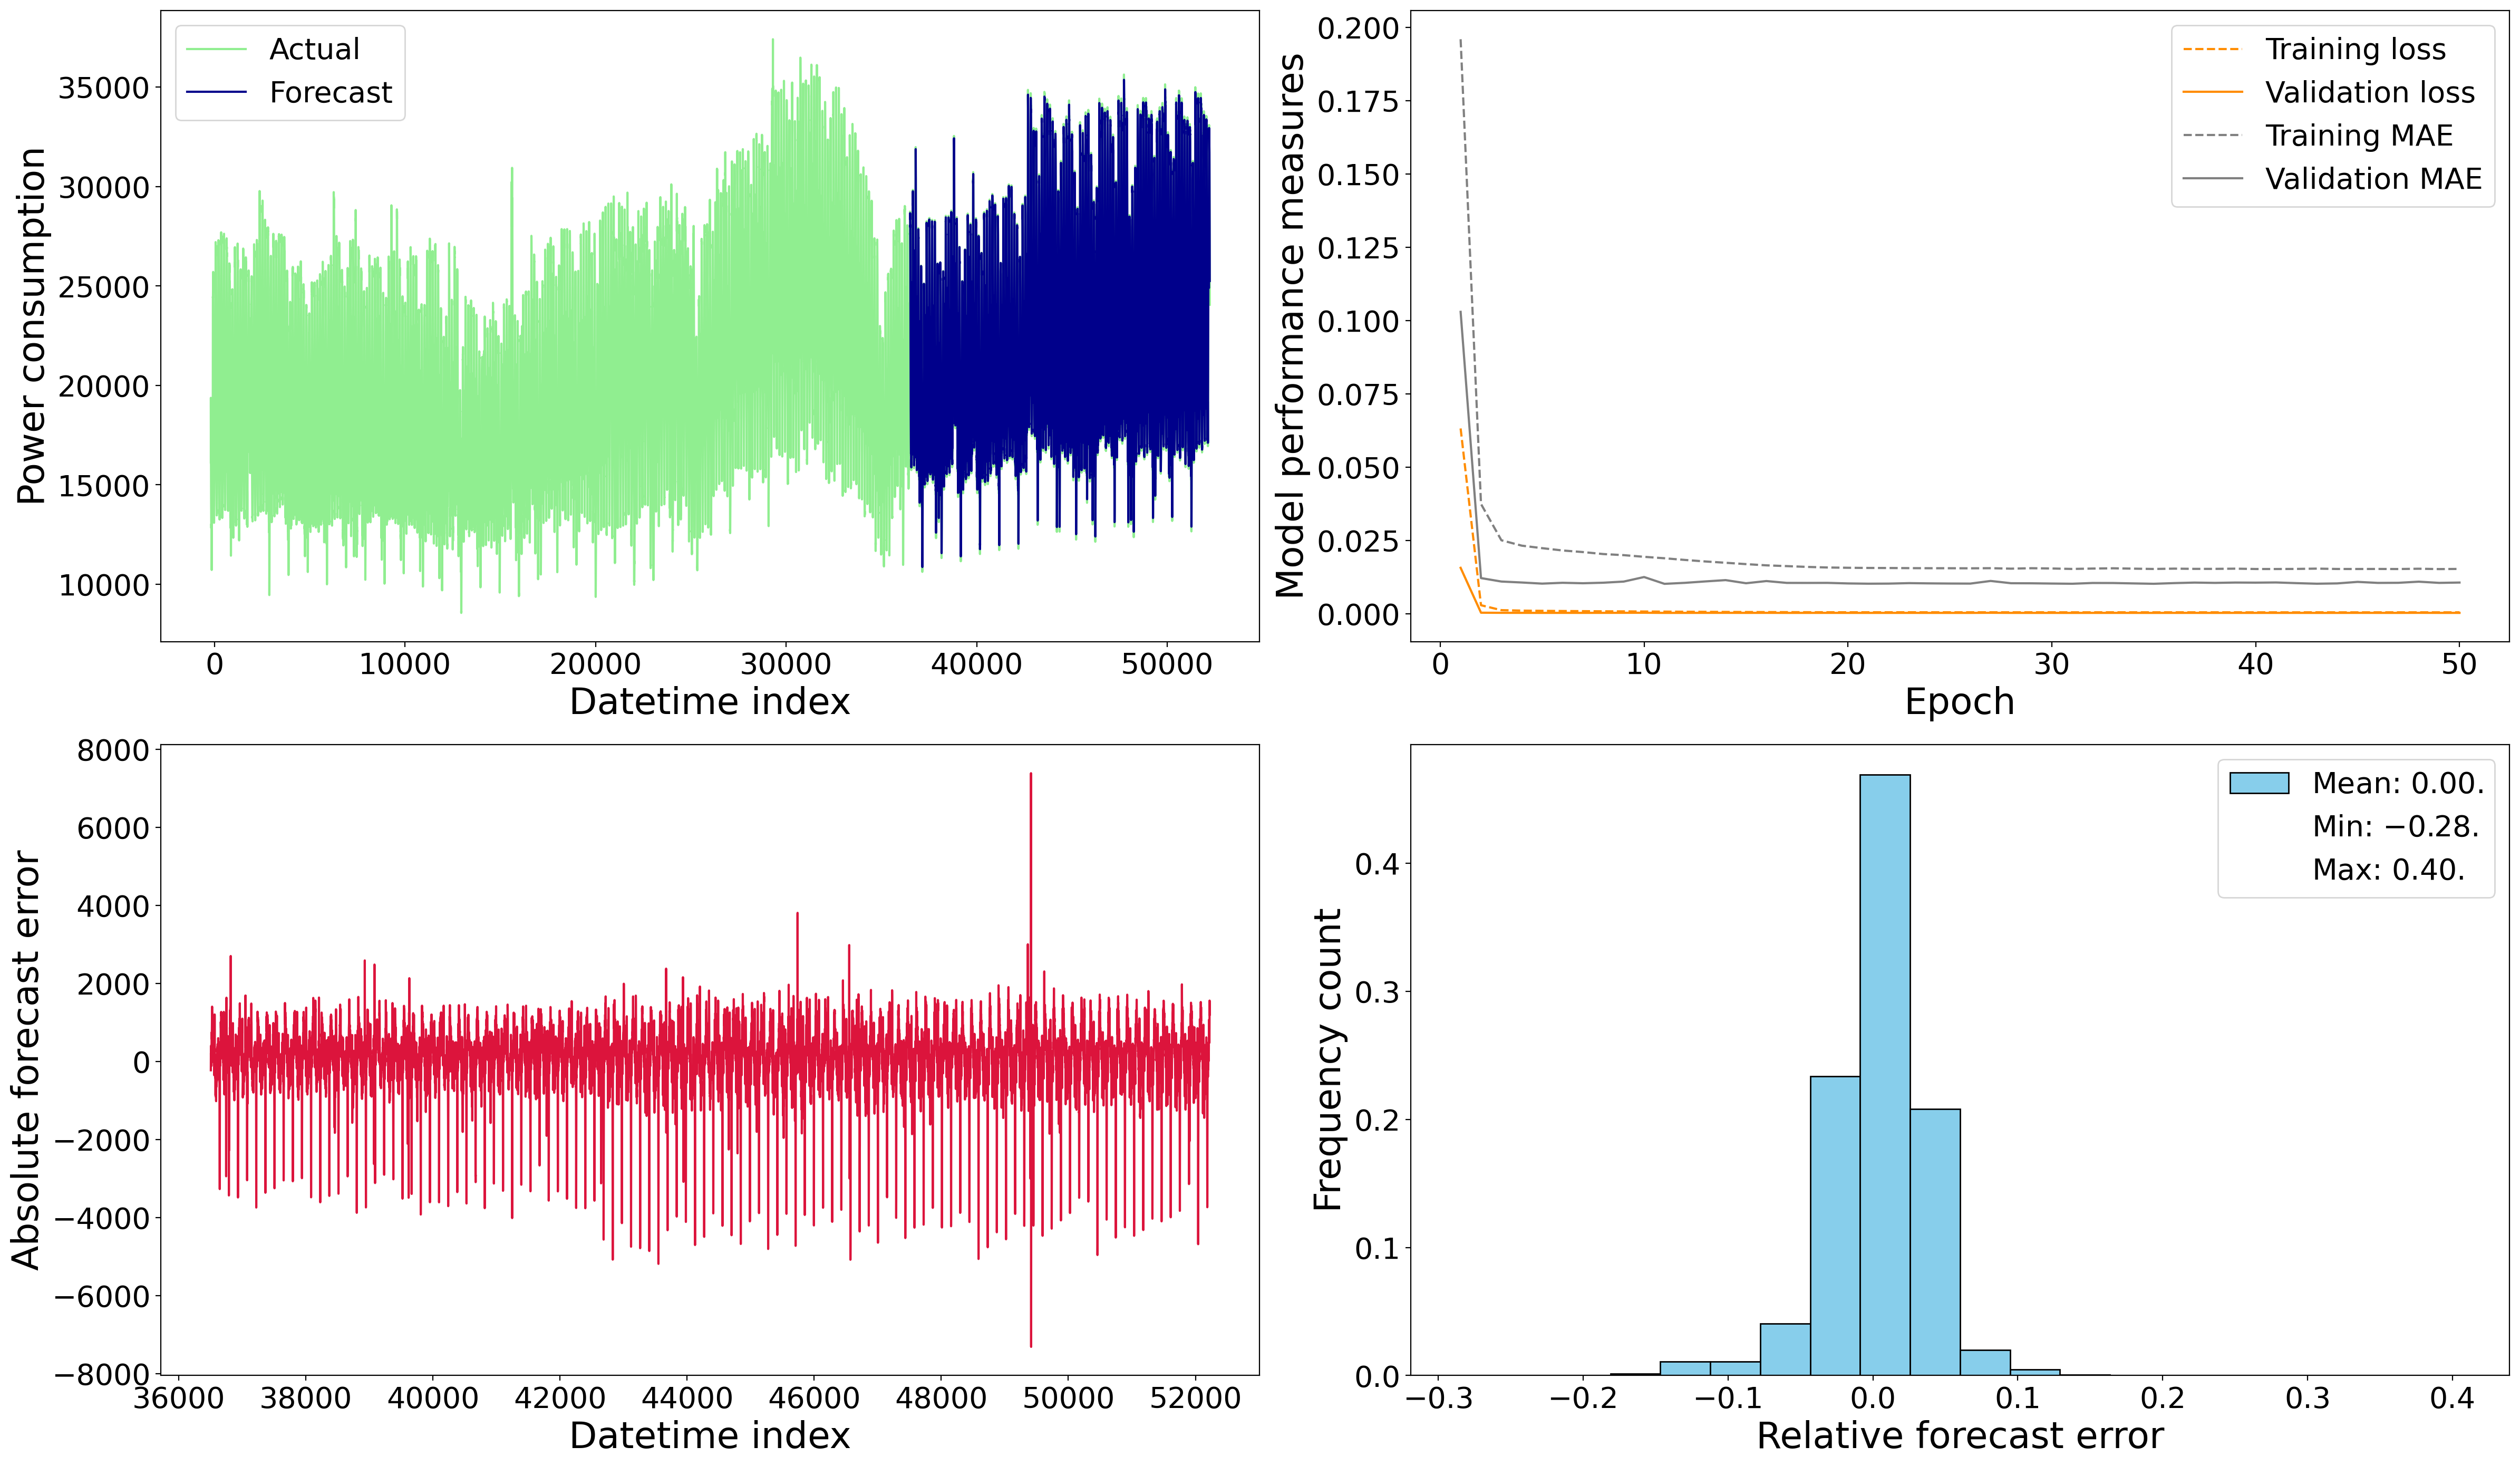

In [530]:
yhat_test_inv = yhat(model, x_train, x_test)
forecast_plot(yhat_test_inv, df_ts, history, epochs, 
              save = False,
              name = 'pred_year_ep50_batch128_lstm4_dense5_drop2_lr1e_4')